In [72]:
import sys
import os
from pathlib import Path

p = Path(os.path.abspath(os.getcwd()))
path = Path(p)
sys.path.insert(0, str(path.parent.absolute()) + '/sub')

from imu_processing import *
from plotting import *
import pandas as pd
import numpy as np
from machine_learning import *
from infer_mag import *
import scipy.signal as signal
from scipy.spatial.transform import Rotation as R
import copy

cwd = str(path.parent.parent.absolute())
data_cwd = cwd + '/Data/'
labels = os.listdir(data_cwd + '/Sample')

model_path = cwd+"/Models/"
svm = load_model(model_path + "SVM20230312")

In [77]:
class MagInfer():
    def __init__(self, data):
        self.acc = self._data_to_lst(data, 'acc')
        self.gyro = self._data_to_lst(data, 'gyro')
        self.mag = self._data_to_lst(data, 'mag')
        self.l = len(self.mag[0])
    
    def _data_to_lst(self, data, name):
        res = []
        lst = ['X', 'Y', 'Z']
        
        for i in lst:
            res.append(data[name + i])
        return res
    
    def _tilted_value(self, original, infered):
        cos_angle = np.dot(original, infered)/(np.linalg.norm(original) * np.linalg.norm(infered))
        return math.degrees(math.acos(cos_angle))
    
    def _get_orientation(self, start, end):
        res = []
        for i in range(3):
            g = np.array(self.gyro[i][start:end]).sum() * 0.01
            res.append(g)
        #print('Roll pitch yaw {} {} {}'.format(res[0], res[1], res[2]))
        
        return self.convert_to_rotation(res)
    
    def convert_to_rotation(self, orientation):
        r = R.from_euler('xyz', orientation, degrees = False)
        
        return r.as_matrix()
    
    def _get_magnetometer_magnitude(self, t):
        res = np.array([self.mag[i][t]*self.mag[i][t] for i in range(3)]).sum()
        
        return math.sqrt(res)
    
    def _is_detect(self, tilted_angle, diff_mag, t):
        pass
        
    
    def solve(self, ws = 0.1, th = 20, cutoff = 10):
        b, a = signal.butter(5, cutoff/(100/2), btype='highpass')
        interval = int(ws * 100)
        state = 0
        
        self.tilted_values = []
        self.magnitudes = []
        self.diff_ref_real = []
        
        for t in range(interval, self.l):
            orientation = self._get_orientation(t-interval, t)
            real_mag = np.array([self.mag[i][t] for i in range(3)])
            reference_mag = np.array([self.mag[i][t-interval] for i in range(3)])
            infered_mag = np.matmul(np.linalg.inv(orientation), reference_mag)
            
            magnitude_mag = self._get_magnetometer_magnitude(t)
            
            self.magnitudes.append(magnitude_mag)
            tilted_angle = self._tilted_value(infered_mag, real_mag)
            self.tilted_values.append(tilted_angle)
            self.diff_ref_real.append(self._tilted_value(reference_mag, real_mag))
            
            if tilted_angle >= th and state == 0:
                print('detect {}'.format(t))
                state = 1
            

C:\Users\jaemi\lab_magacc/Data/Test_inside/NoObject/Imu 2023-04-10 12-11-01


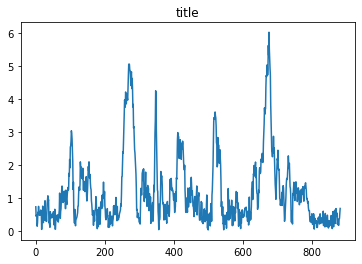

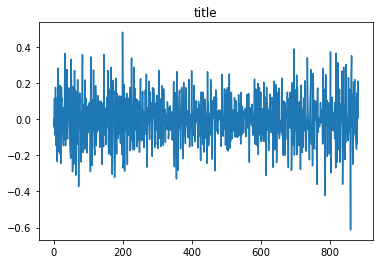

In [71]:
import scipy.signal as signal

path = data_cwd + 'test0331/'
#path = data_cwd + 'Test_outside/outside'
path = data_cwd + 'Test_nature2'
path = data_cwd + 'Test_inside'
b, a = signal.butter(5, 10/(100/2), btype='highpass')
imu_data = IMU(path)
f = imu_data[4]
print(f.path)
data = f.data

tmp = MagInfer(data)
tmp.solve()
tilted_value = tmp.tilted_values
plot_graph(tilted_value)
filtered_data = signal.filtfilt(b, a, tmp.magnitudes)
plot_graph(filtered_data)

C:\Users\jaemi\lab_magacc/Data/Test_nature1/bandgripBlack/Imu 2023-03-29 14-41-46
detect 356


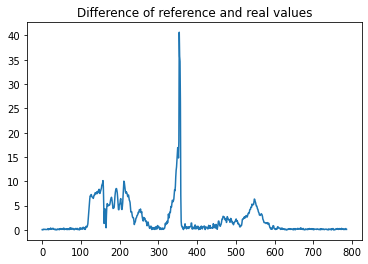

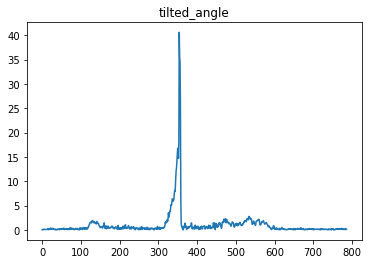

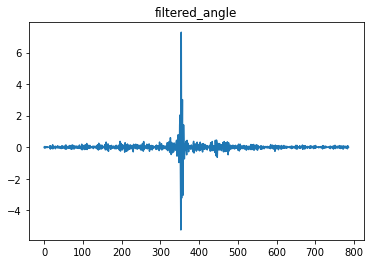

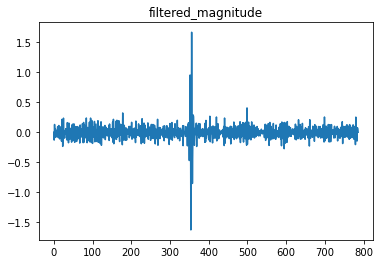

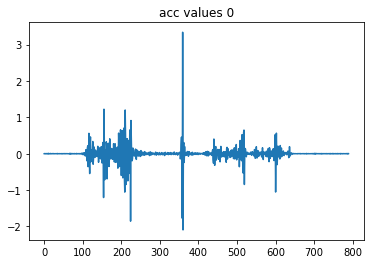

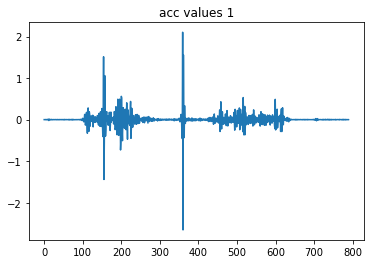

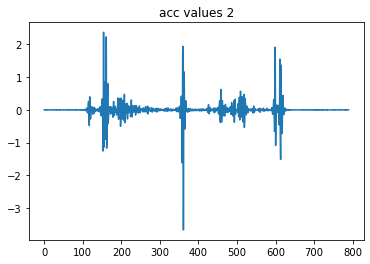

angle max 40.62506711483989  magnitude max : 1.6694651541056955

C:\Users\jaemi\lab_magacc/Data/Test_nature1/bandgripBlack/Imu 2023-03-29 14-42-02
detect 359


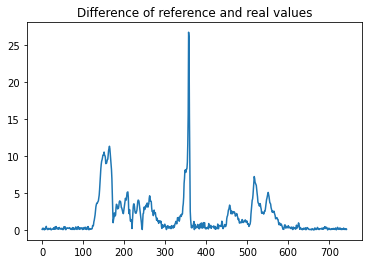

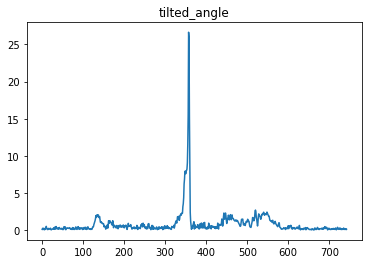

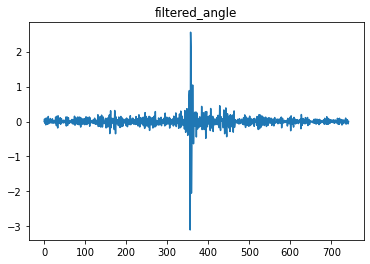

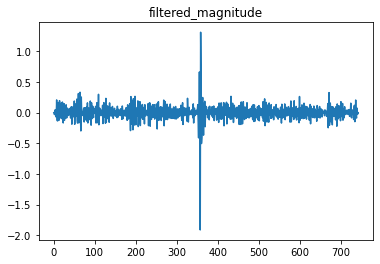

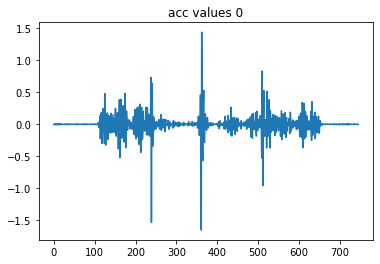

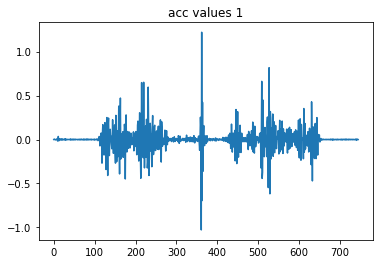

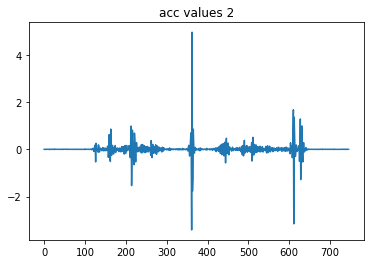

angle max 26.650333713558553  magnitude max : 1.9125167605615845

C:\Users\jaemi\lab_magacc/Data/Test_nature1/bandgripBlack/Imu 2023-03-29 14-42-18
detect 321


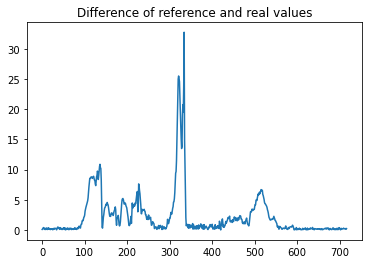

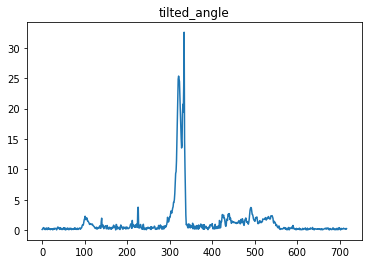

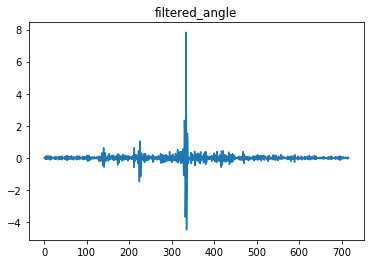

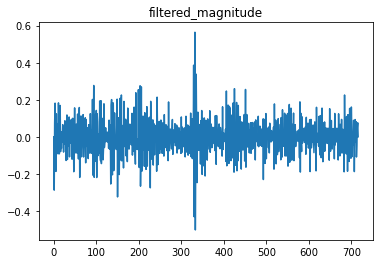

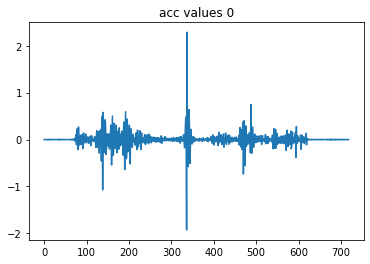

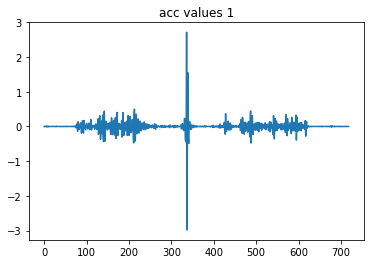

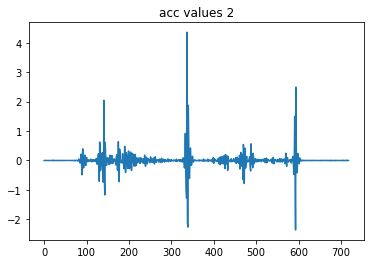

angle max 32.57586516154218  magnitude max : 0.5643913977927897

C:\Users\jaemi\lab_magacc/Data/Test_nature1/bandgripBlack/Imu 2023-03-29 14-42-34
detect 367


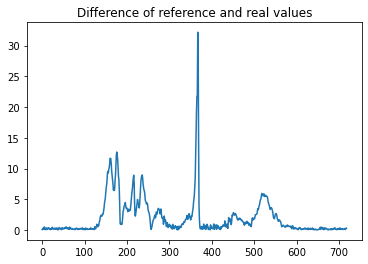

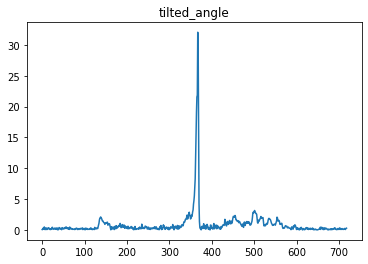

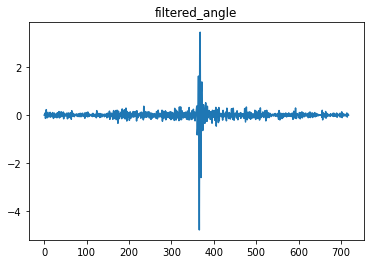

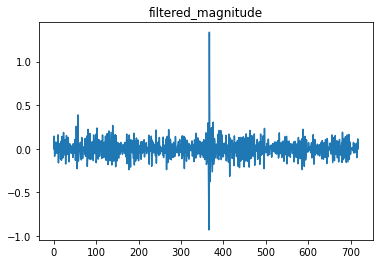

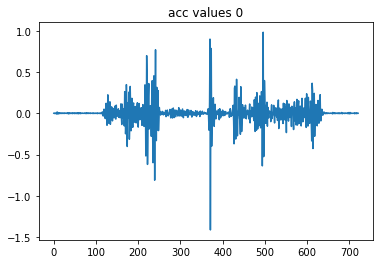

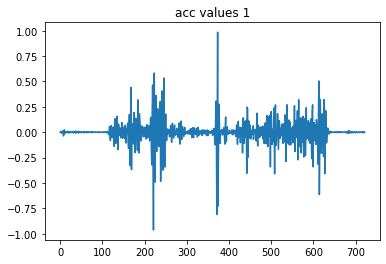

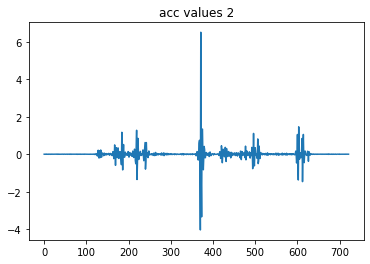

angle max 32.06046567612001  magnitude max : 1.336352285834819

C:\Users\jaemi\lab_magacc/Data/Test_nature1/bandgripBlack/Imu 2023-03-29 14-42-48
detect 310


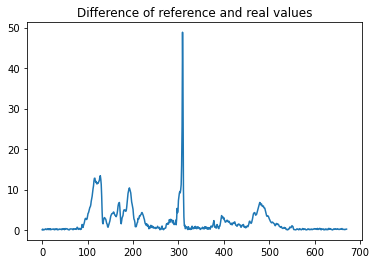

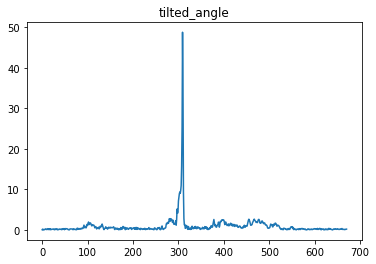

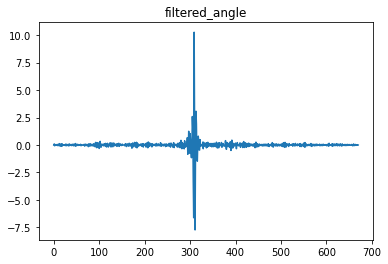

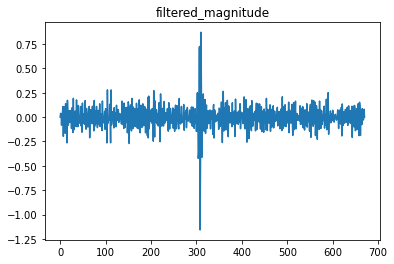

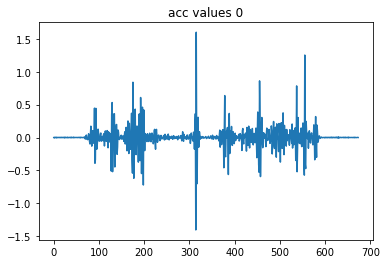

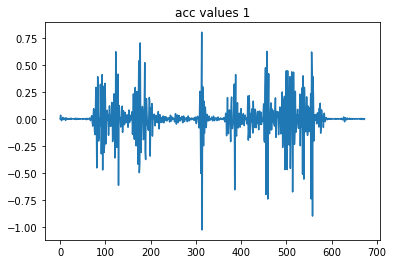

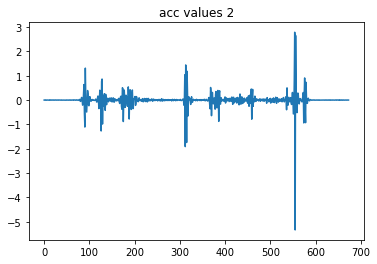

angle max 48.8098796140488  magnitude max : 1.1571846619639858

C:\Users\jaemi\lab_magacc/Data/Test_nature1/bandgripBlue/Imu 2023-03-29 14-47-10
detect 351


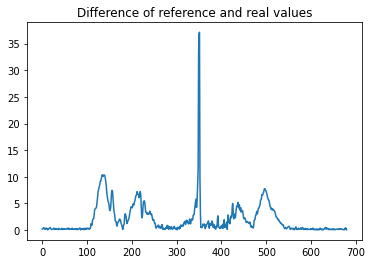

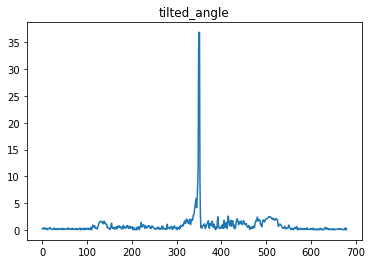

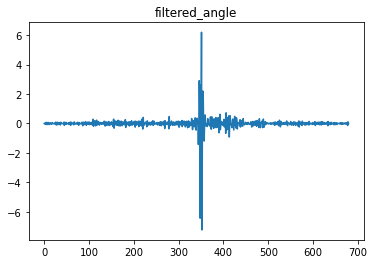

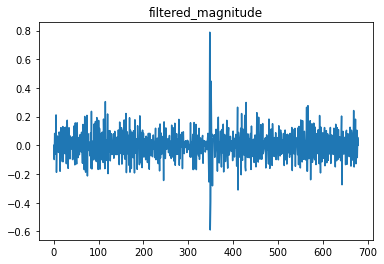

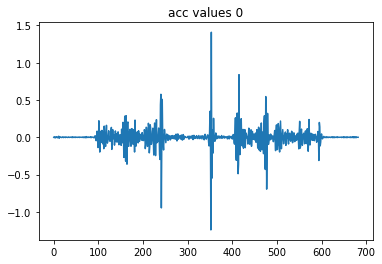

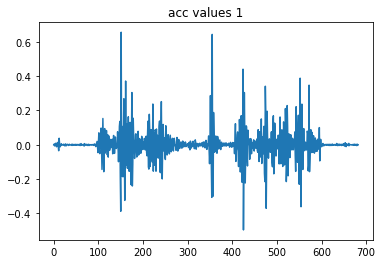

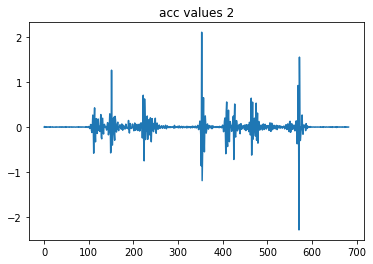

angle max 36.889110257289744  magnitude max : 0.7878560703654384

C:\Users\jaemi\lab_magacc/Data/Test_nature1/bandgripBlue/Imu 2023-03-29 14-47-26
detect 347


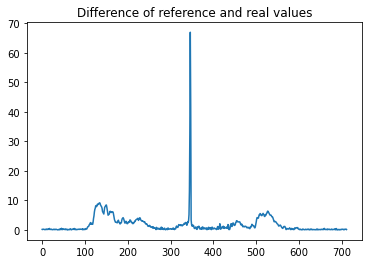

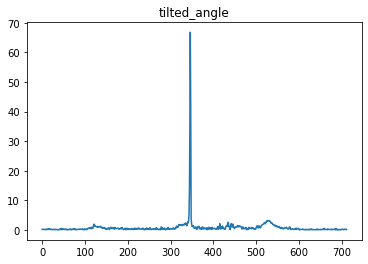

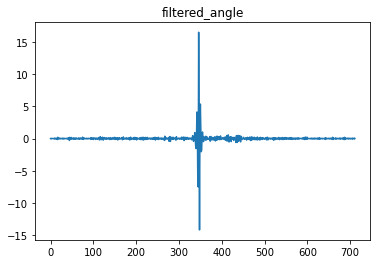

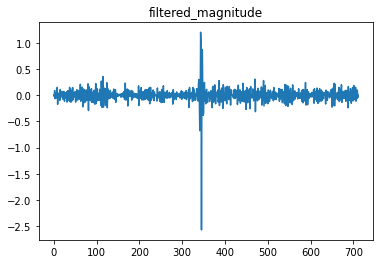

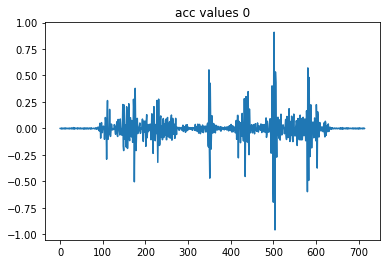

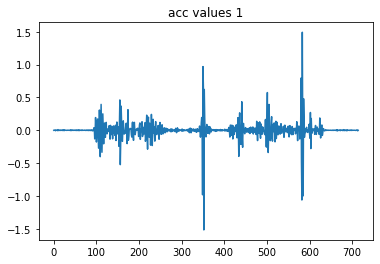

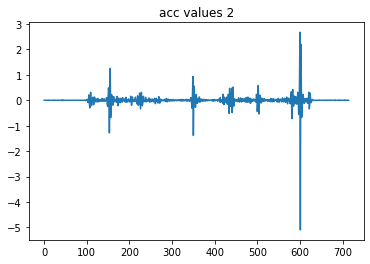

angle max 66.79996691184903  magnitude max : 2.574923206951571

C:\Users\jaemi\lab_magacc/Data/Test_nature1/bandgripBlue/Imu 2023-03-29 14-47-40
detect 312


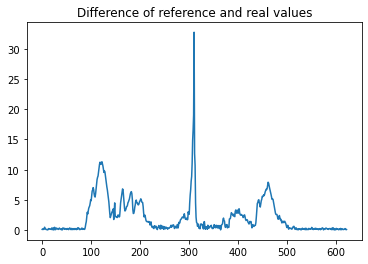

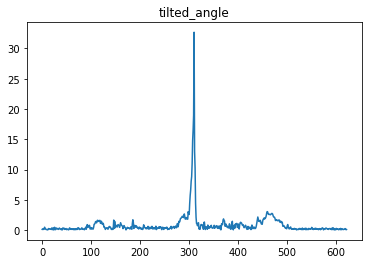

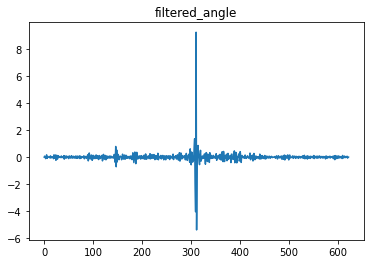

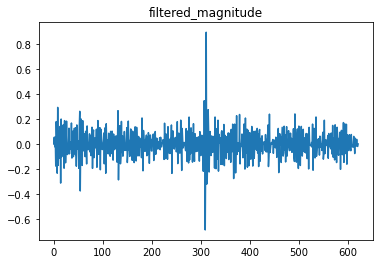

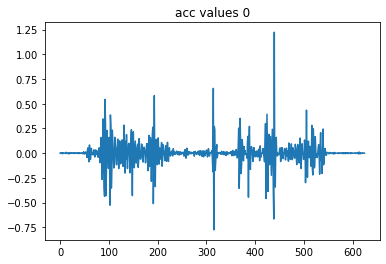

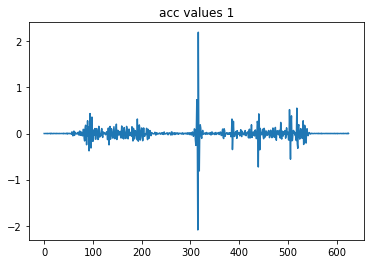

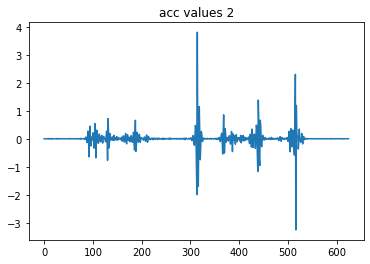

angle max 32.66459344842515  magnitude max : 0.8955340578779871

C:\Users\jaemi\lab_magacc/Data/Test_nature1/bandgripBlue/Imu 2023-03-29 14-47-55
detect 286


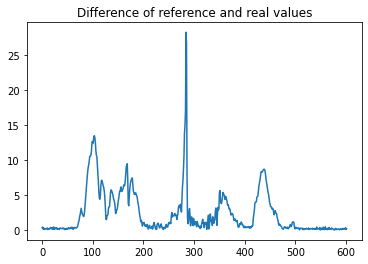

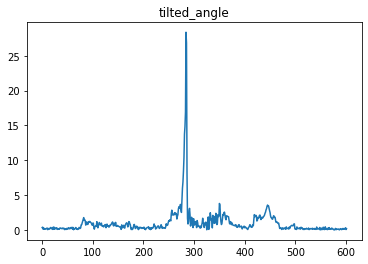

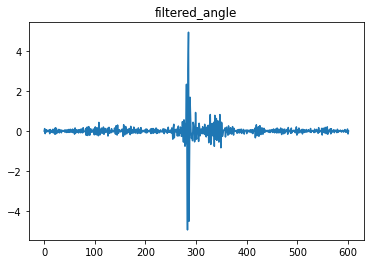

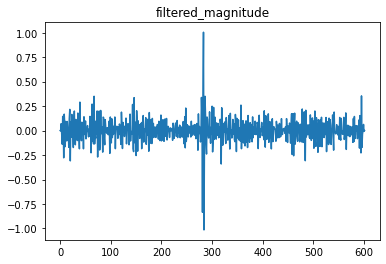

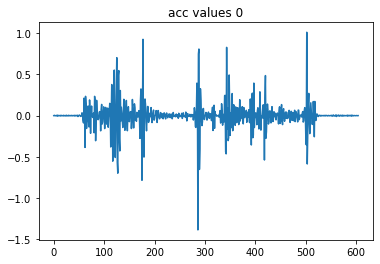

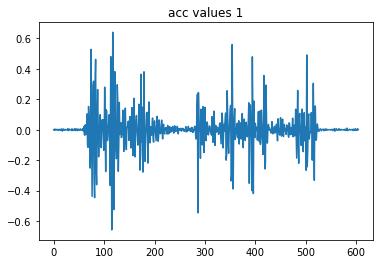

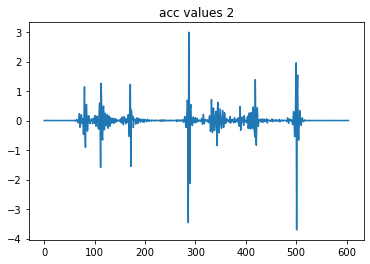

angle max 28.366760333226303  magnitude max : 1.014830529016185

C:\Users\jaemi\lab_magacc/Data/Test_nature1/bandgripBlue/Imu 2023-03-29 14-48-11
detect 288


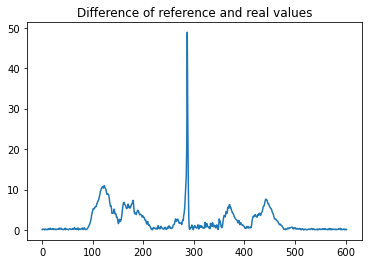

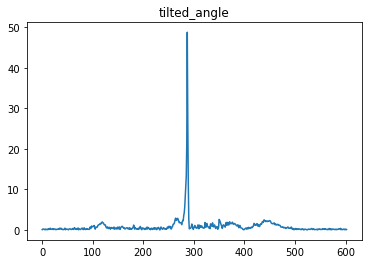

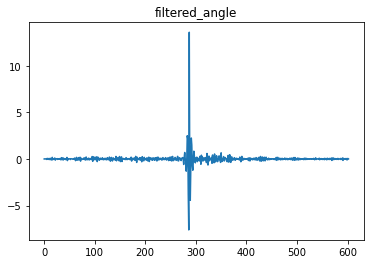

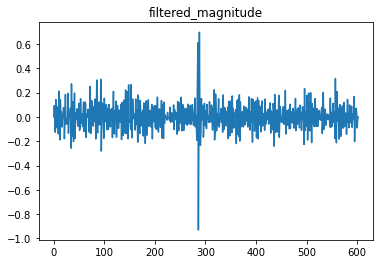

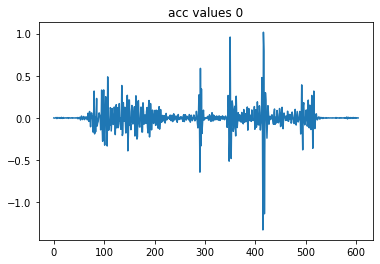

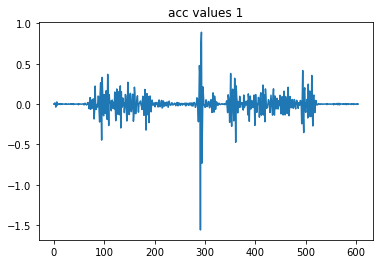

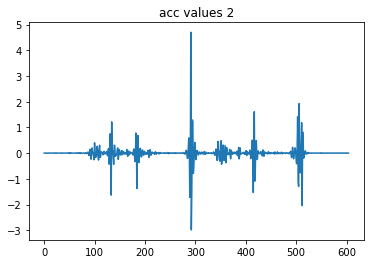

angle max 48.78623597364588  magnitude max : 0.9294073915779681

C:\Users\jaemi\lab_magacc/Data/Test_nature1/batterypack/Imu 2023-03-29 14-55-38


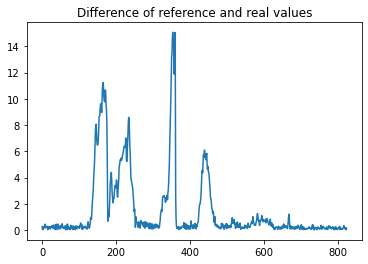

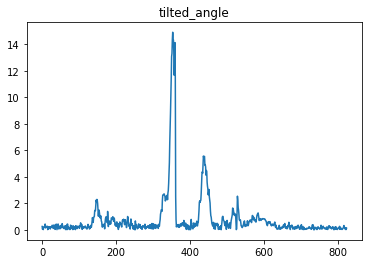

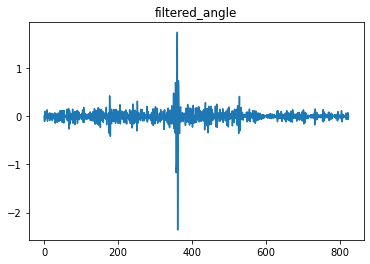

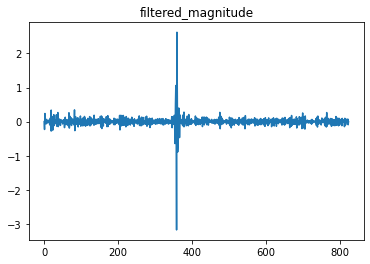

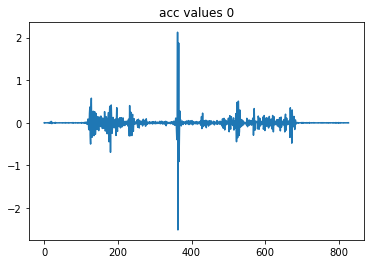

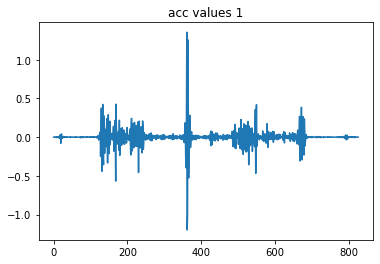

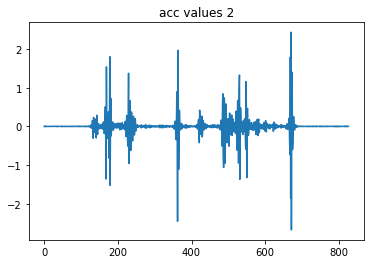

angle max 14.918306370011264  magnitude max : 3.1770275040807374

C:\Users\jaemi\lab_magacc/Data/Test_nature1/batterypack/Imu 2023-03-29 14-55-54


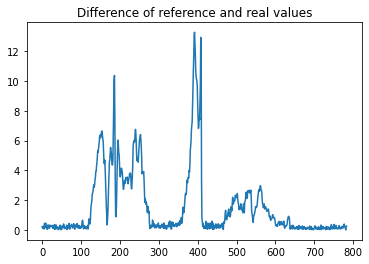

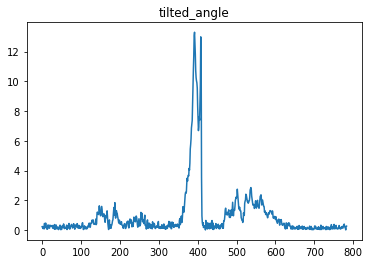

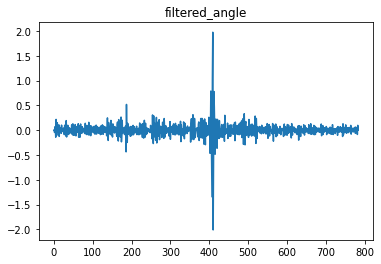

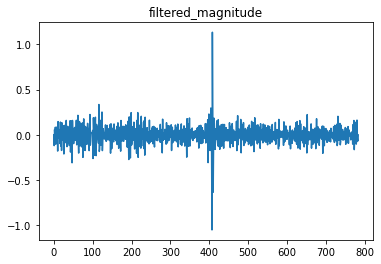

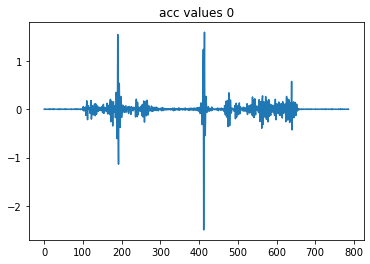

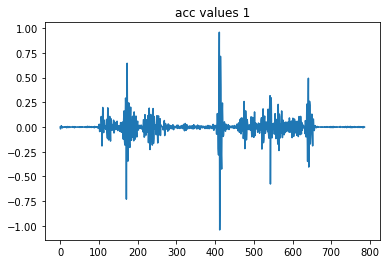

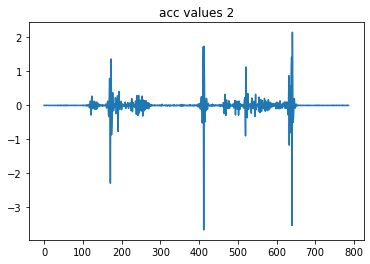

angle max 13.29441832777456  magnitude max : 1.1342691117829728

C:\Users\jaemi\lab_magacc/Data/Test_nature1/batterypack/Imu 2023-03-29 15-06-12
detect 388


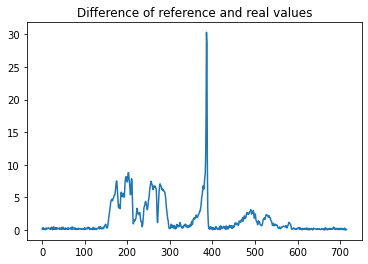

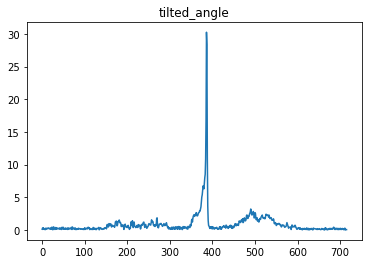

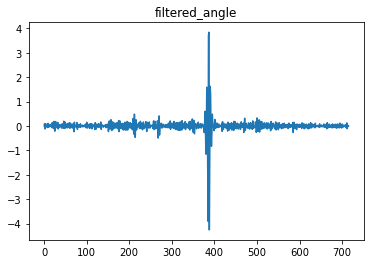

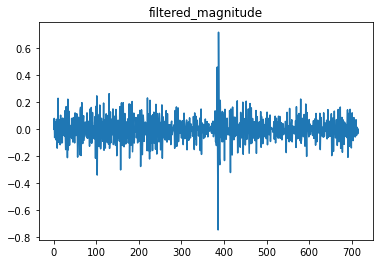

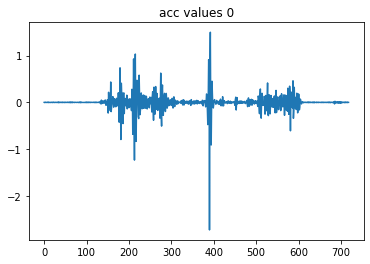

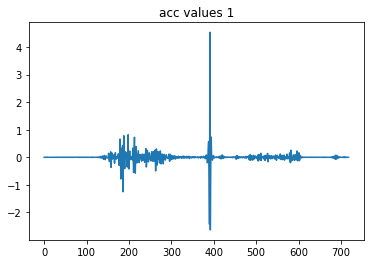

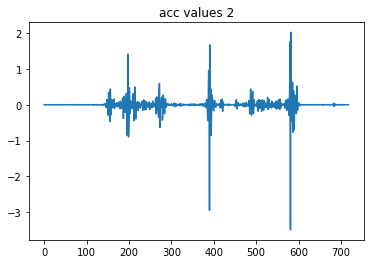

angle max 30.246341469642324  magnitude max : 0.7461673671961075

C:\Users\jaemi\lab_magacc/Data/Test_nature1/batterypack/Imu 2023-03-29 15-06-31
detect 299


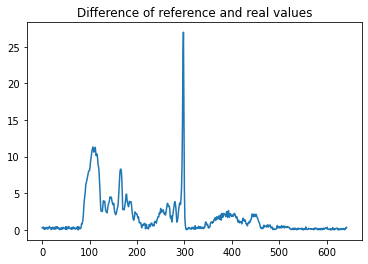

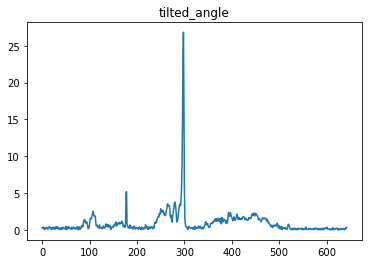

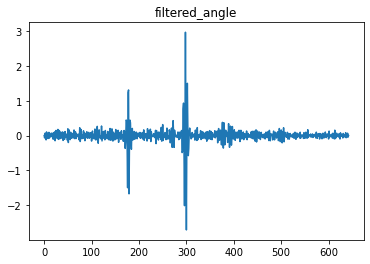

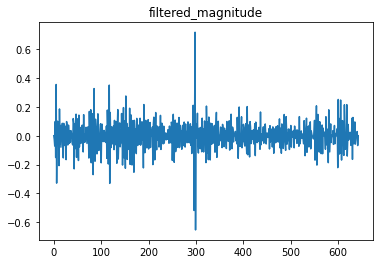

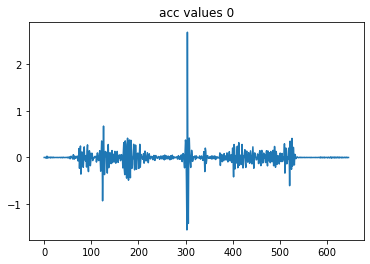

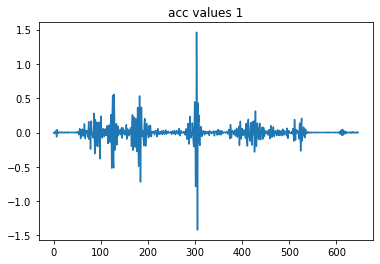

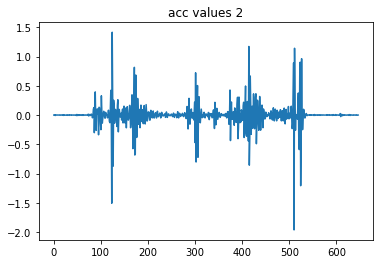

angle max 26.842402853879015  magnitude max : 0.7171957712561577

C:\Users\jaemi\lab_magacc/Data/Test_nature1/batterypack/Imu 2023-03-29 15-06-52
detect 296


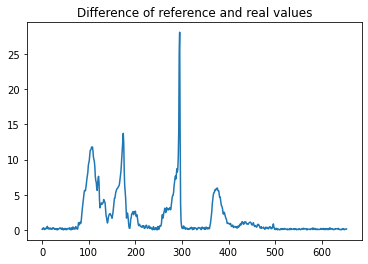

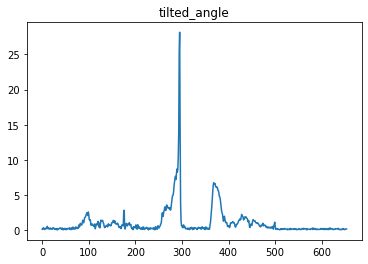

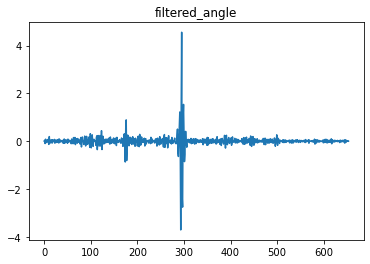

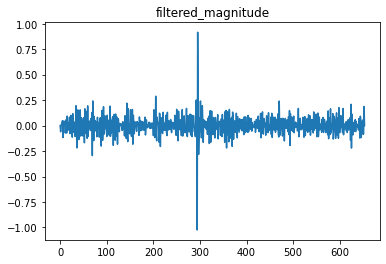

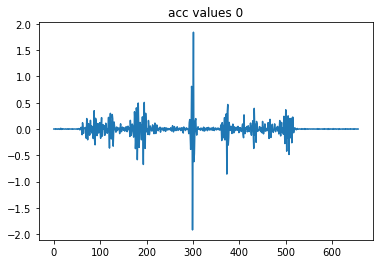

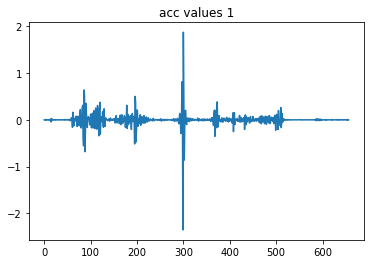

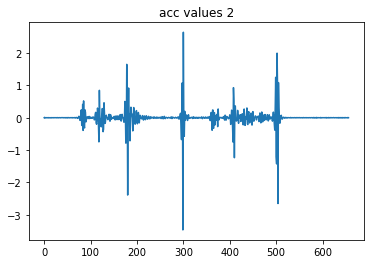

angle max 28.16441612151487  magnitude max : 1.0237920900744104

C:\Users\jaemi\lab_magacc/Data/Test_nature1/blackcowlabsGriptokBlack/Imu 2023-03-29 14-52-17


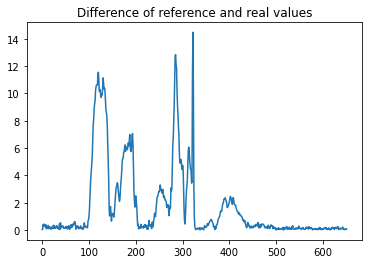

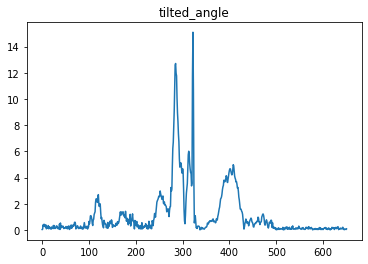

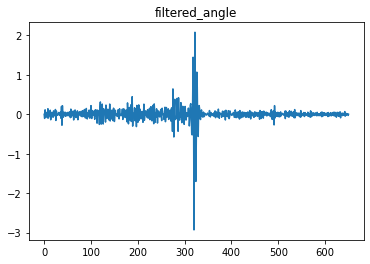

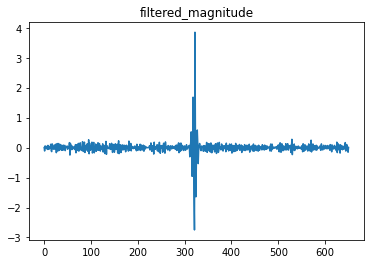

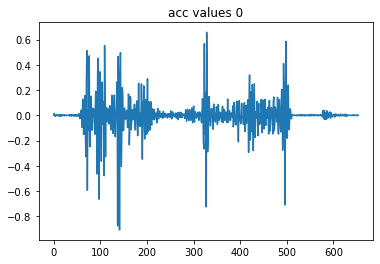

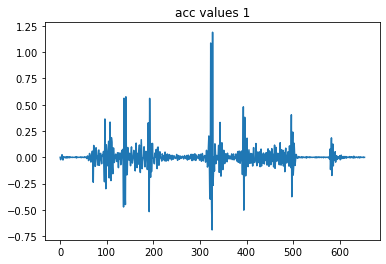

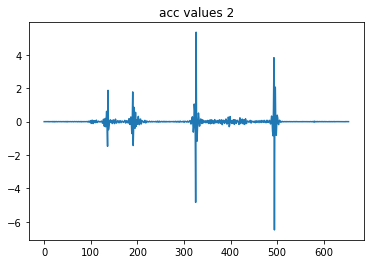

angle max 15.09239051318629  magnitude max : 3.8496272749909006

C:\Users\jaemi\lab_magacc/Data/Test_nature1/blackcowlabsGriptokBlack/Imu 2023-03-29 14-52-32
detect 312


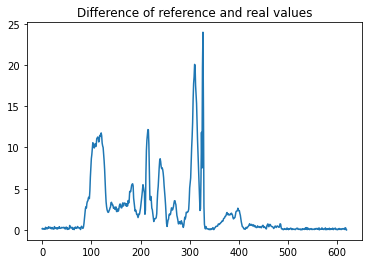

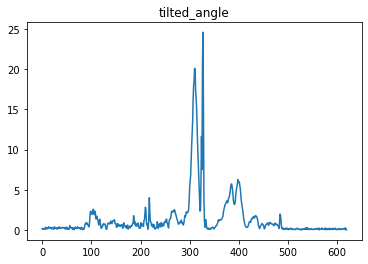

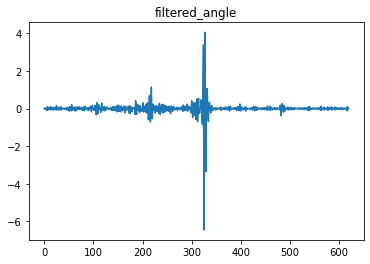

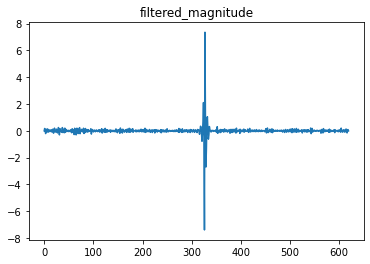

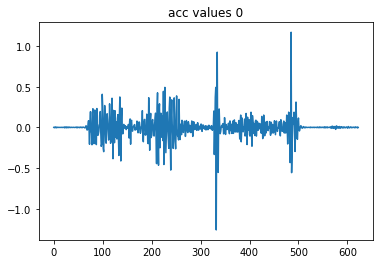

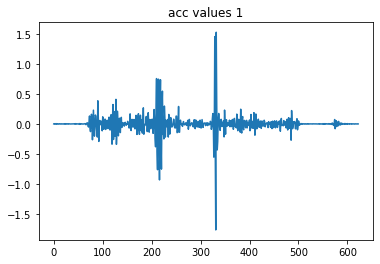

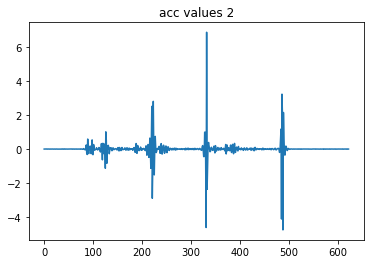

angle max 24.589887102307525  magnitude max : 7.390600260485757

C:\Users\jaemi\lab_magacc/Data/Test_nature1/blackcowlabsGriptokBlack/Imu 2023-03-29 14-52-50
detect 307


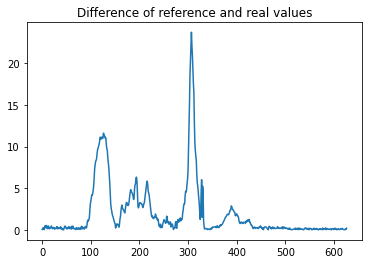

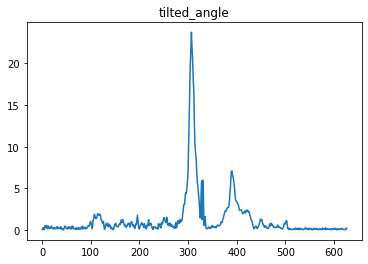

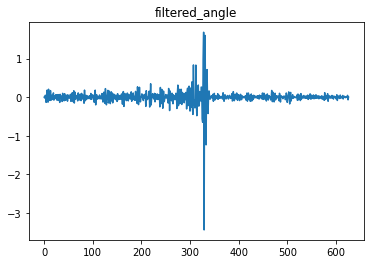

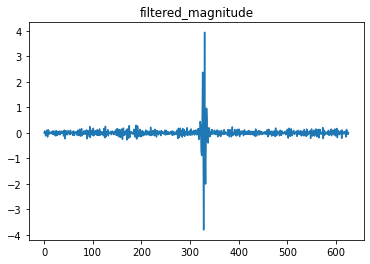

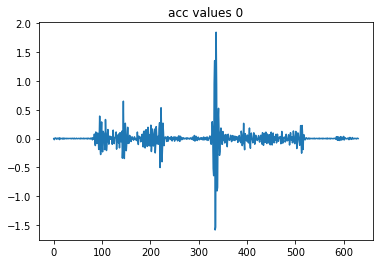

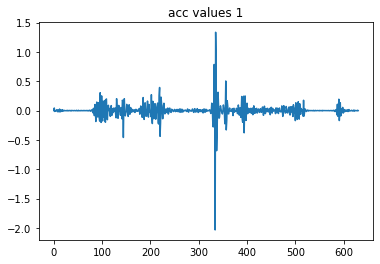

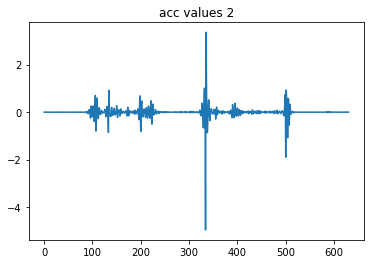

angle max 23.73665701420319  magnitude max : 3.9443424220820655

C:\Users\jaemi\lab_magacc/Data/Test_nature1/blackcowlabsGriptokBlack/Imu 2023-03-29 14-53-05


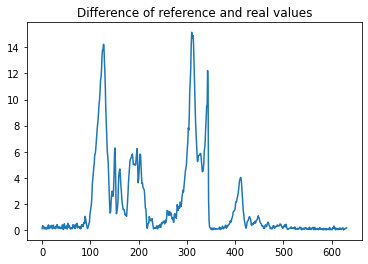

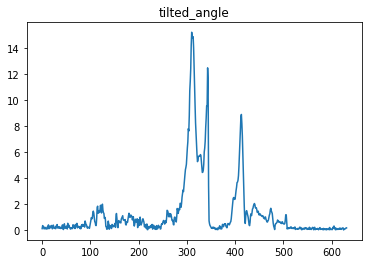

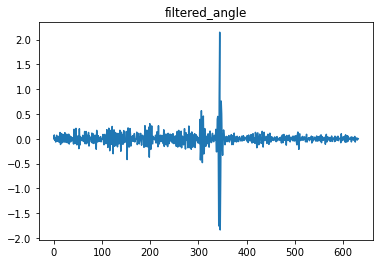

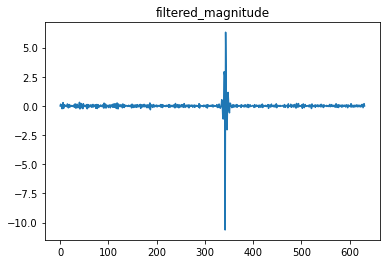

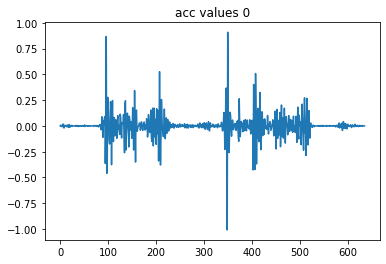

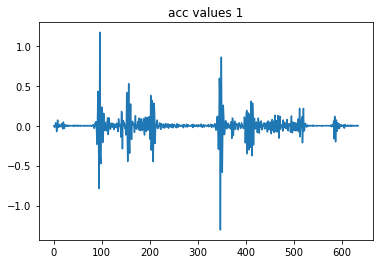

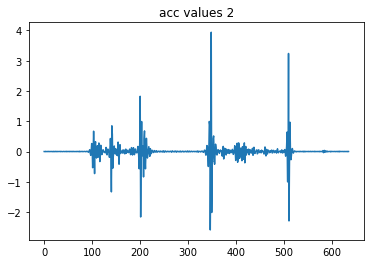

angle max 15.21092988062467  magnitude max : 10.63053832796185

C:\Users\jaemi\lab_magacc/Data/Test_nature1/blackcowlabsGriptokBlack/Imu 2023-03-29 14-53-27


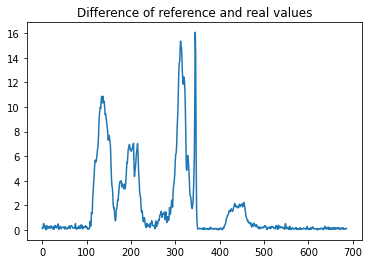

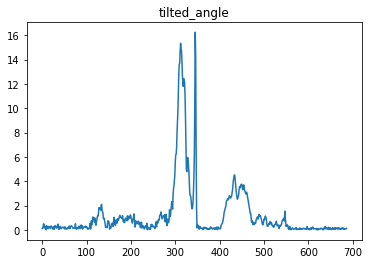

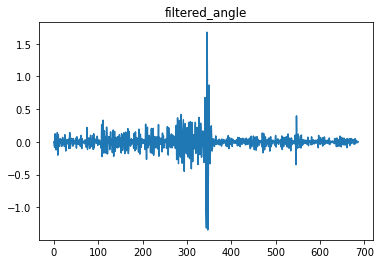

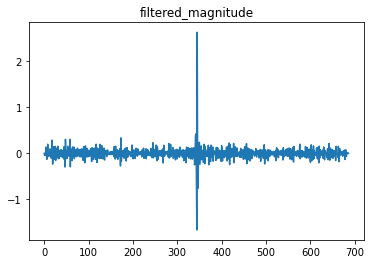

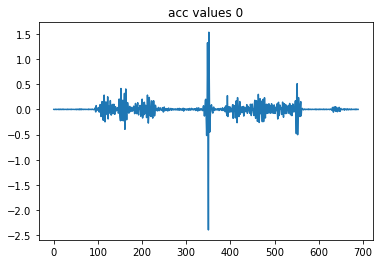

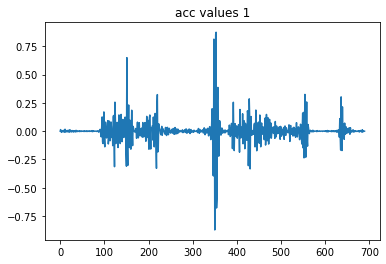

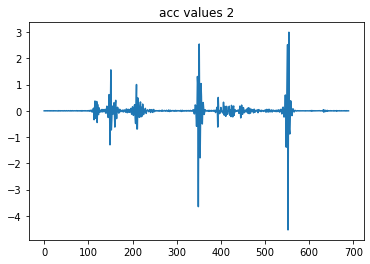

angle max 16.238894738440745  magnitude max : 2.6270121876026065

C:\Users\jaemi\lab_magacc/Data/Test_nature1/casetifyWalletBlack/Imu 2023-03-29 14-45-33


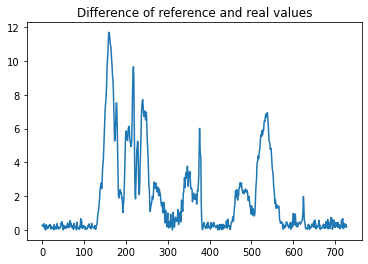

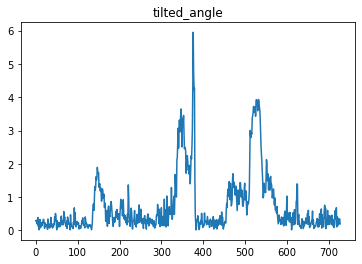

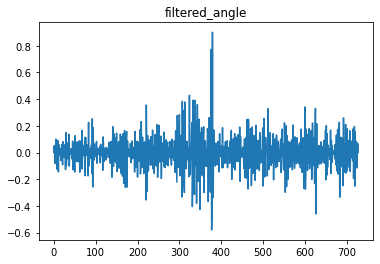

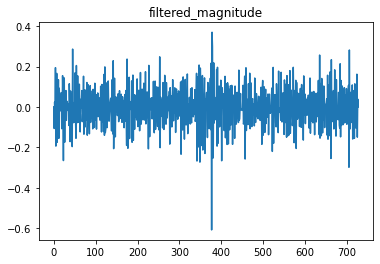

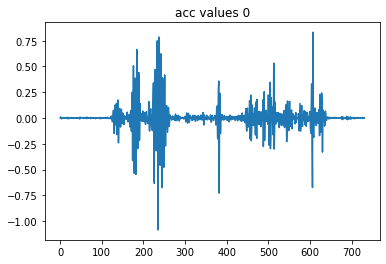

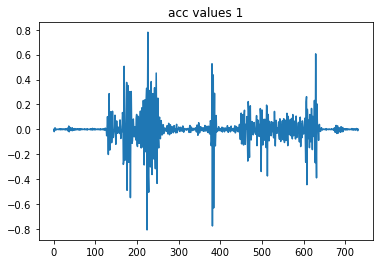

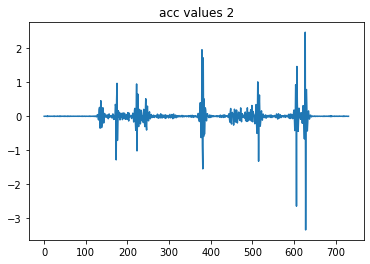

angle max 5.95175756028347  magnitude max : 0.6090682165428342

C:\Users\jaemi\lab_magacc/Data/Test_nature1/casetifyWalletBlack/Imu 2023-03-29 14-45-49


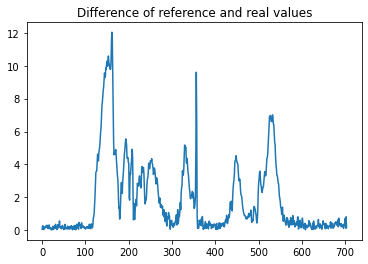

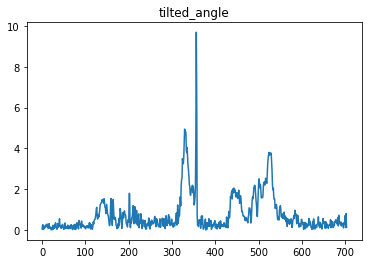

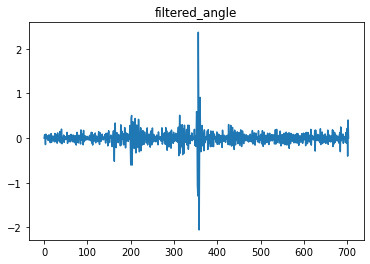

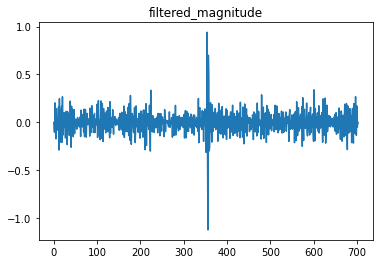

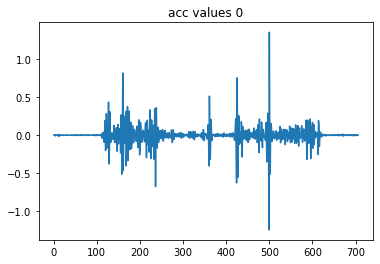

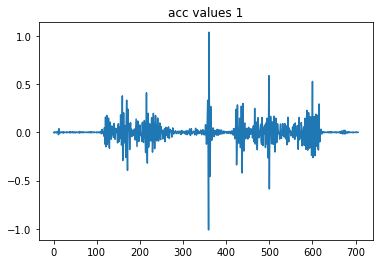

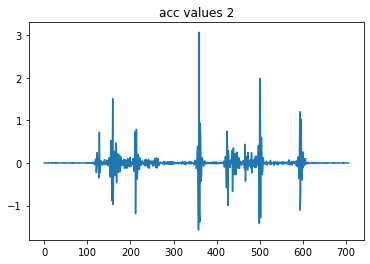

angle max 9.686793898740898  magnitude max : 1.1207827011460836

C:\Users\jaemi\lab_magacc/Data/Test_nature1/casetifyWalletBlack/Imu 2023-03-29 14-46-04


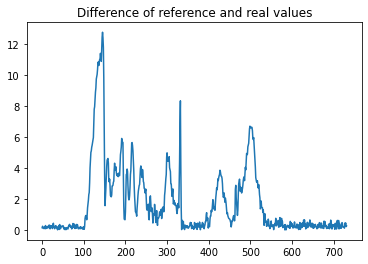

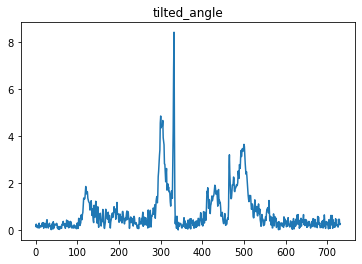

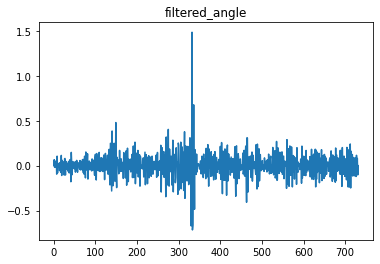

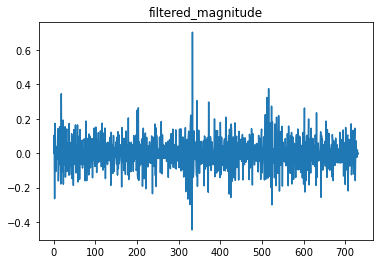

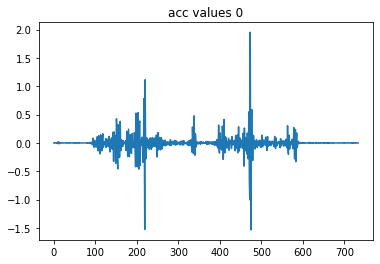

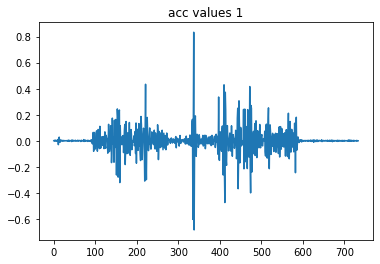

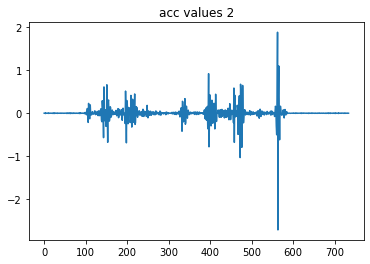

angle max 8.40355602551919  magnitude max : 0.7014139068899926

C:\Users\jaemi\lab_magacc/Data/Test_nature1/casetifyWalletBlack/Imu 2023-03-29 14-46-19


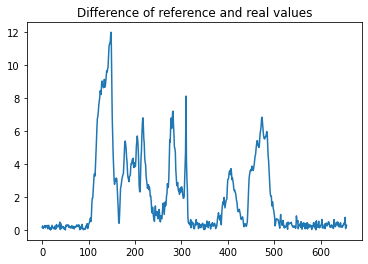

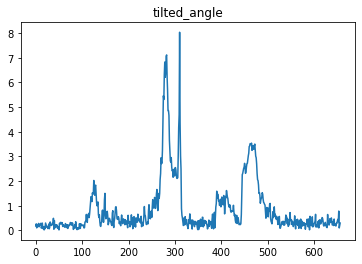

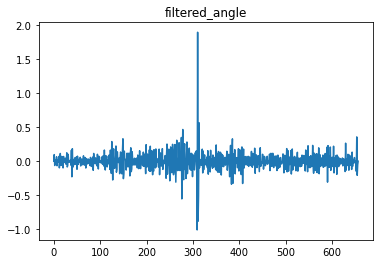

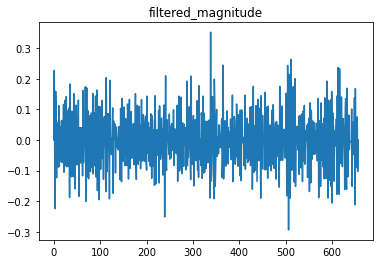

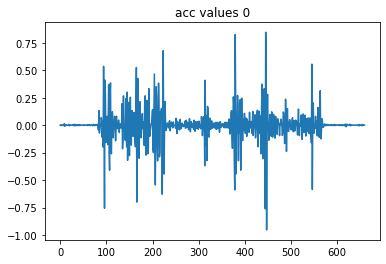

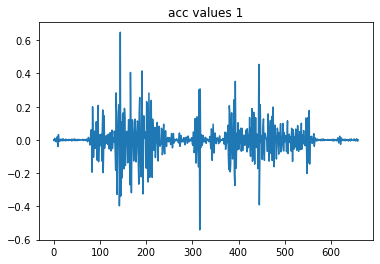

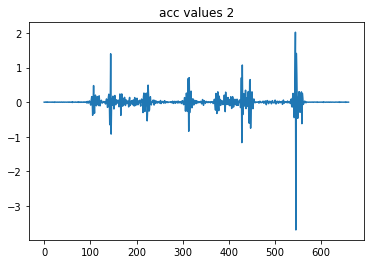

angle max 8.034569847463814  magnitude max : 0.3520935132232304

C:\Users\jaemi\lab_magacc/Data/Test_nature1/casetifyWalletBlack/Imu 2023-03-29 14-46-34


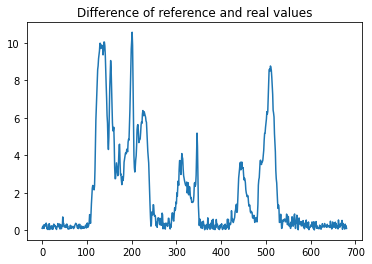

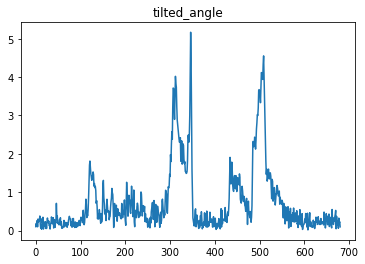

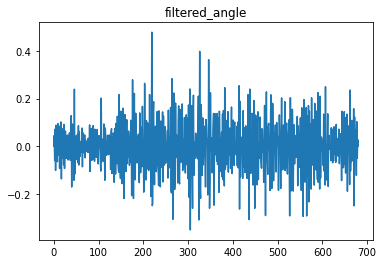

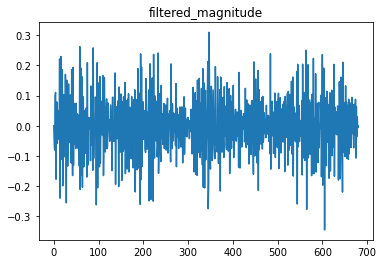

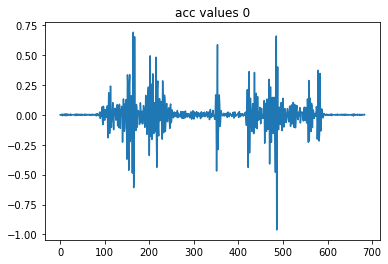

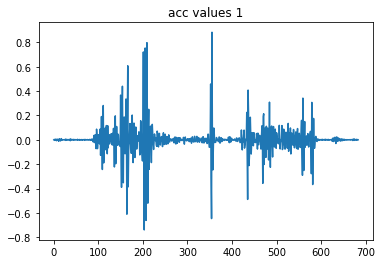

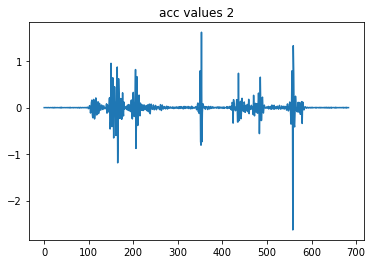

angle max 5.168188242572615  magnitude max : 0.34548974296075163

C:\Users\jaemi\lab_magacc/Data/Test_nature1/chargerBlack/Imu 2023-03-29 15-22-37
detect 319


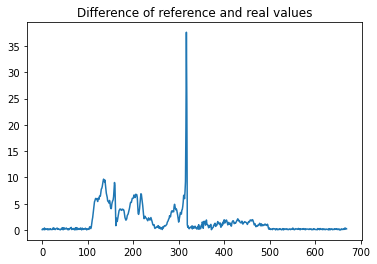

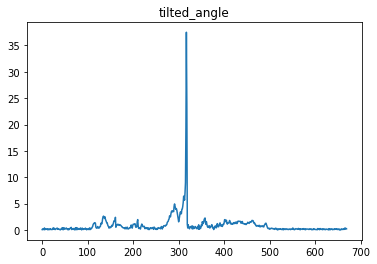

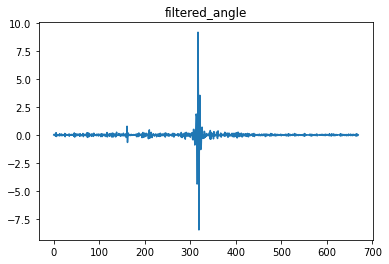

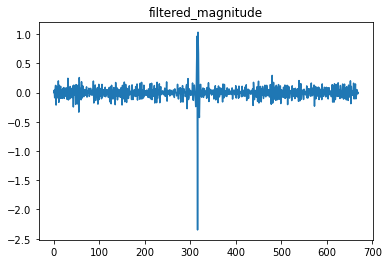

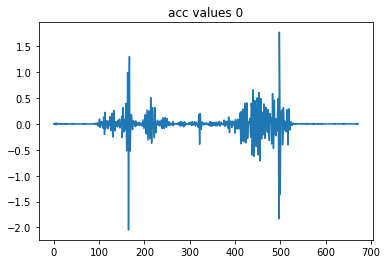

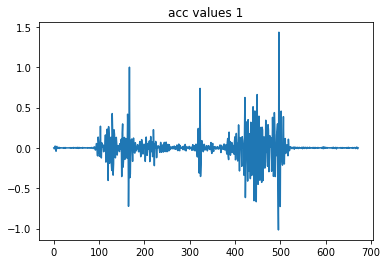

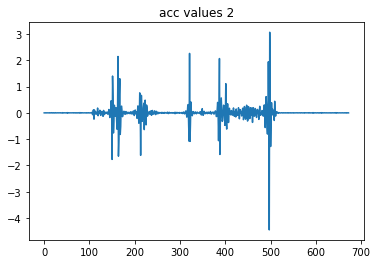

angle max 37.50168022531881  magnitude max : 2.3502231560986253

C:\Users\jaemi\lab_magacc/Data/Test_nature1/chargerBlack/Imu 2023-03-29 15-22-53


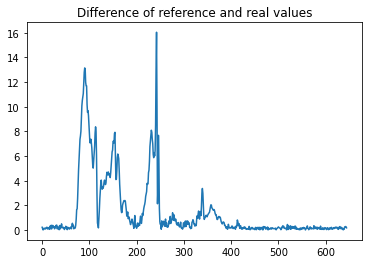

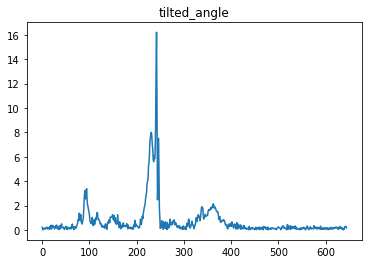

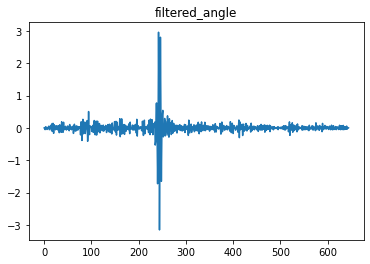

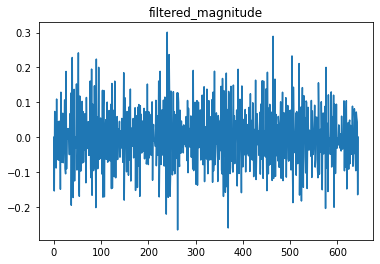

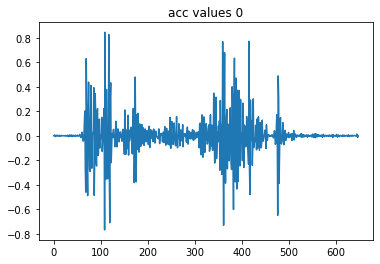

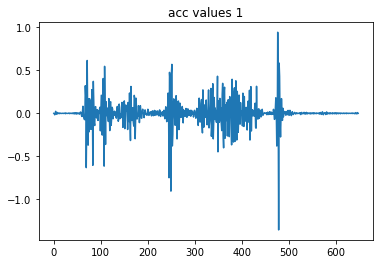

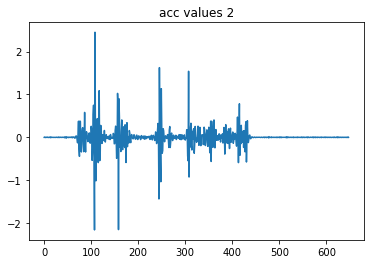

angle max 16.208284859861926  magnitude max : 0.3008333392689117

C:\Users\jaemi\lab_magacc/Data/Test_nature1/chargerBlack/Imu 2023-03-29 15-23-06
detect 271


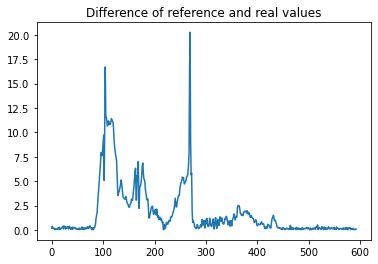

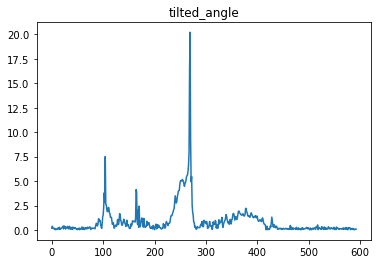

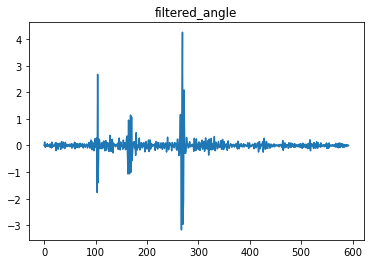

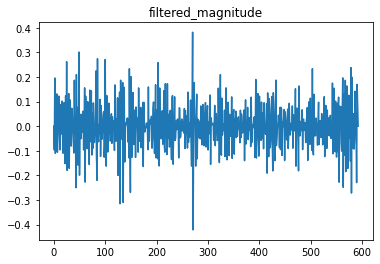

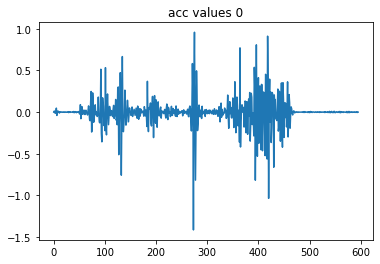

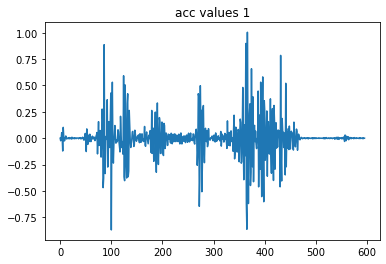

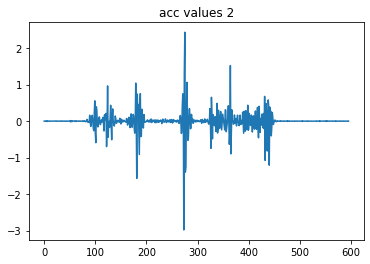

angle max 20.208659605248723  magnitude max : 0.42193608419385736

C:\Users\jaemi\lab_magacc/Data/Test_nature1/chargerBlack/Imu 2023-03-29 15-23-21


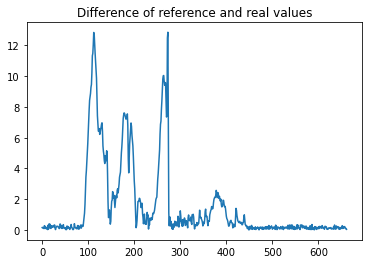

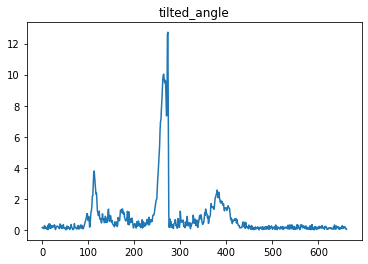

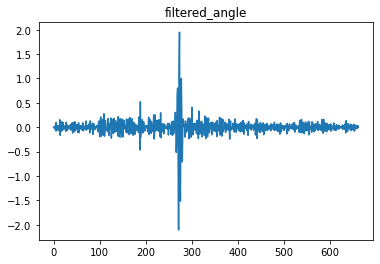

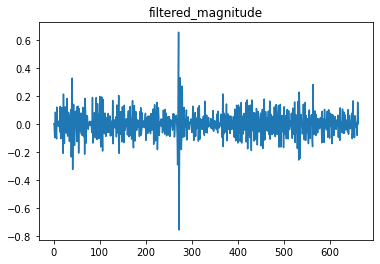

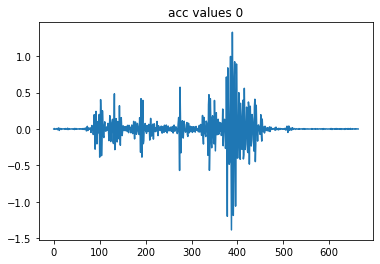

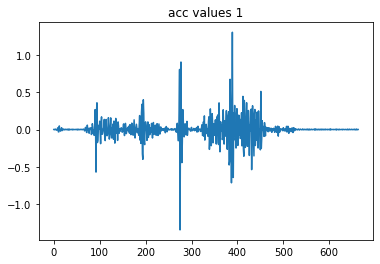

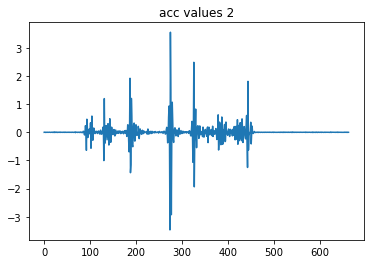

angle max 12.725690199139276  magnitude max : 0.7582030395156537

C:\Users\jaemi\lab_magacc/Data/Test_nature1/chargerBlack/Imu 2023-03-29 15-23-38


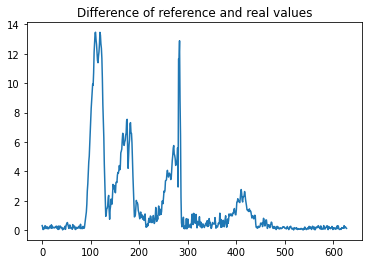

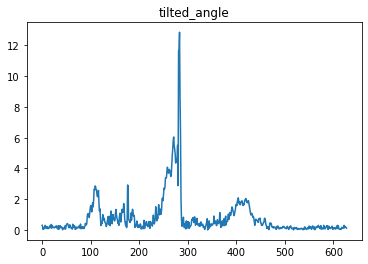

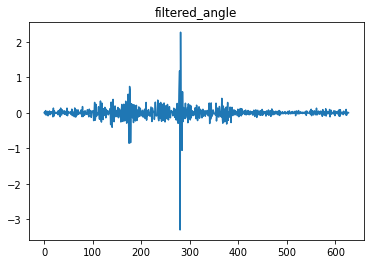

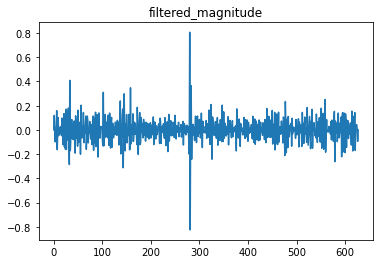

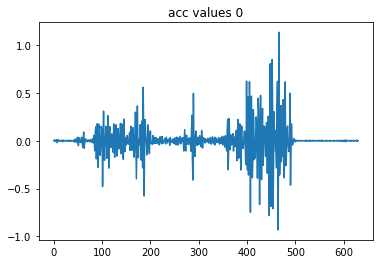

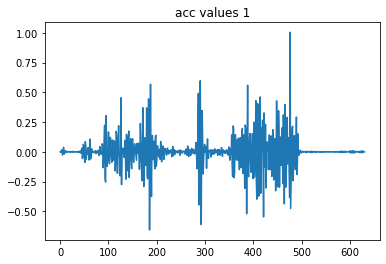

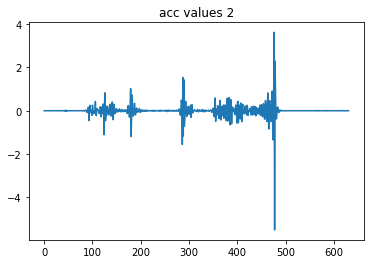

angle max 12.84393977009363  magnitude max : 0.8263430047029721

C:\Users\jaemi\lab_magacc/Data/Test_nature1/gallapleWalletWhite/Imu 2023-03-29 14-48-55
detect 271


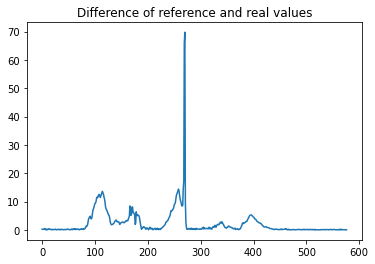

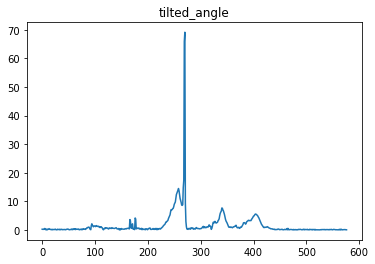

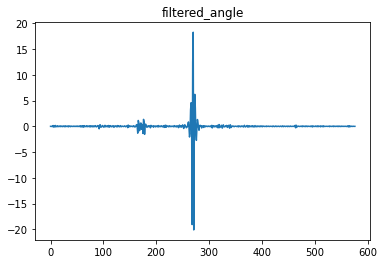

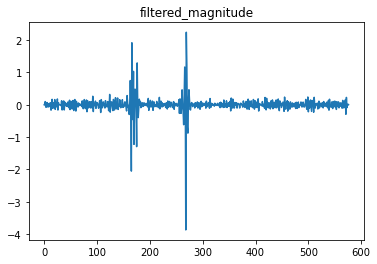

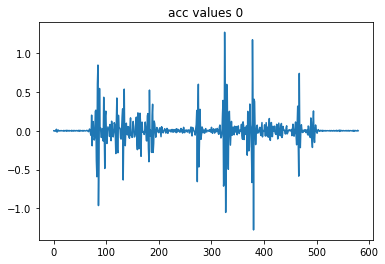

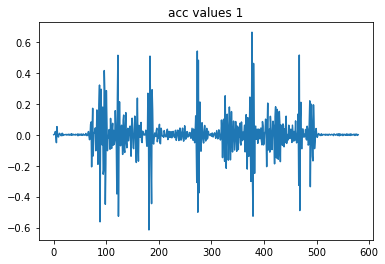

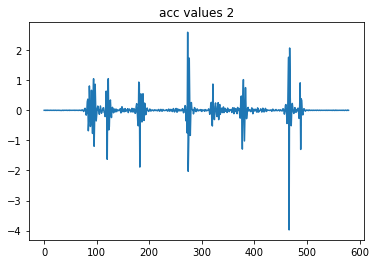

angle max 69.18382070192216  magnitude max : 3.8668094792520304

C:\Users\jaemi\lab_magacc/Data/Test_nature1/gallapleWalletWhite/Imu 2023-03-29 14-49-09
detect 299


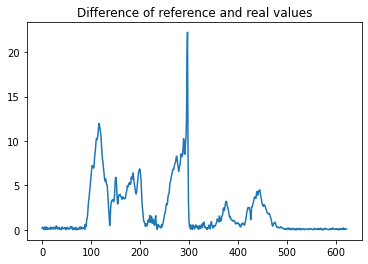

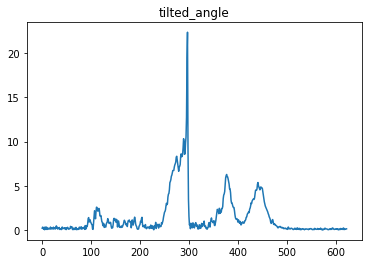

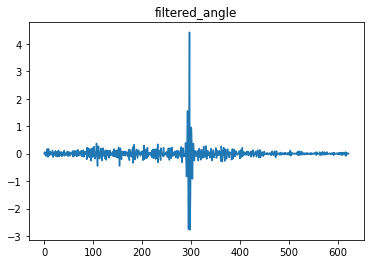

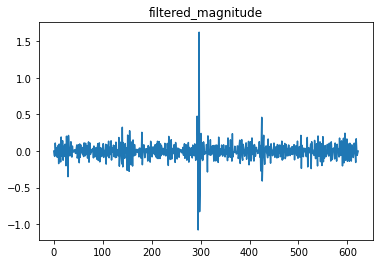

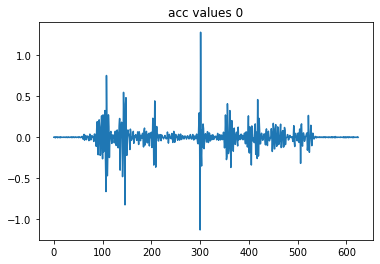

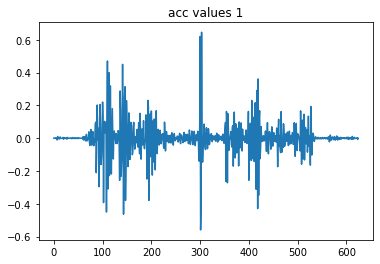

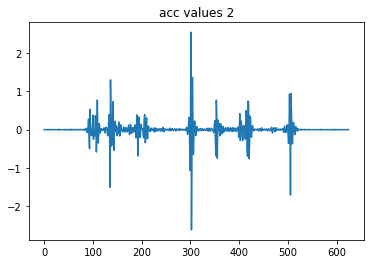

angle max 22.36574286164302  magnitude max : 1.6244071029174896

C:\Users\jaemi\lab_magacc/Data/Test_nature1/gallapleWalletWhite/Imu 2023-03-29 14-49-23
detect 296


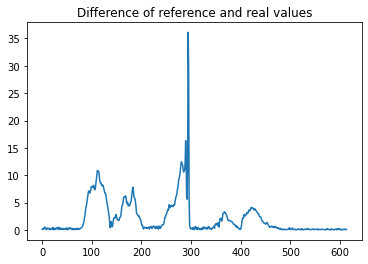

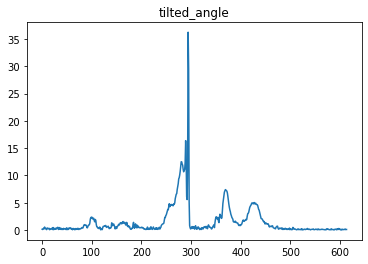

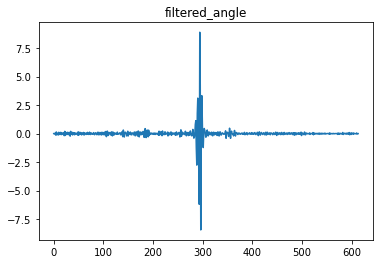

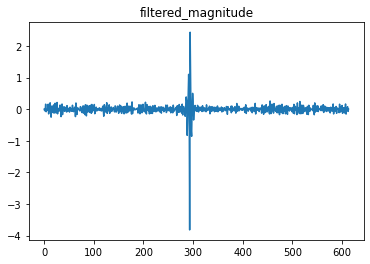

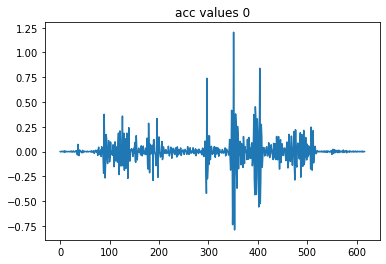

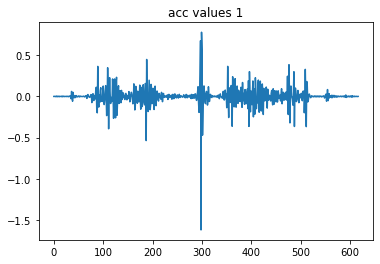

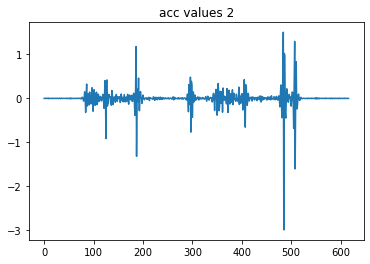

angle max 36.23014737541609  magnitude max : 3.8188511810533394

C:\Users\jaemi\lab_magacc/Data/Test_nature1/gallapleWalletWhite/Imu 2023-03-29 14-49-38
detect 293


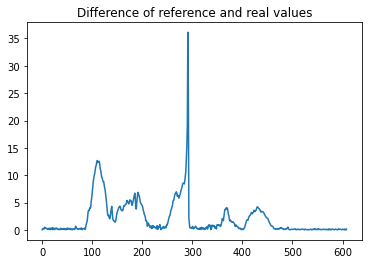

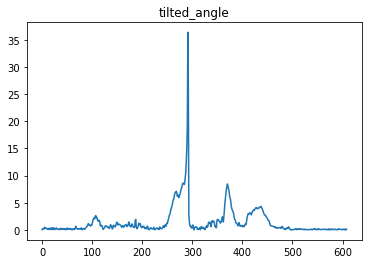

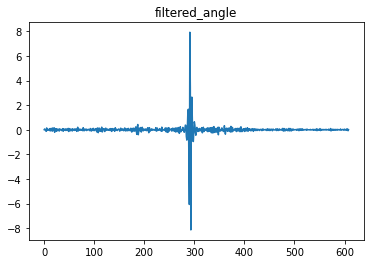

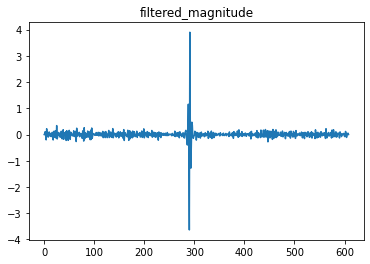

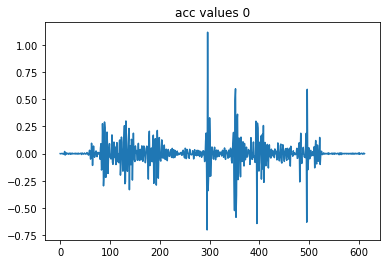

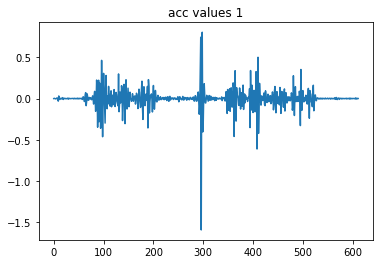

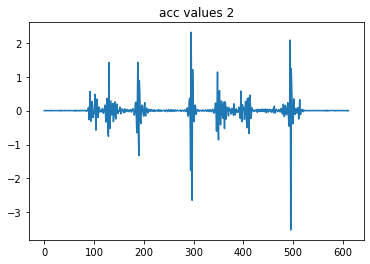

angle max 36.413991762436424  magnitude max : 3.8981334787268858

C:\Users\jaemi\lab_magacc/Data/Test_nature1/gallapleWalletWhite/Imu 2023-03-29 14-49-55
detect 291


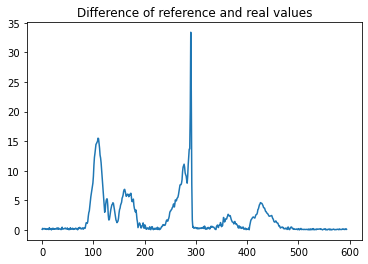

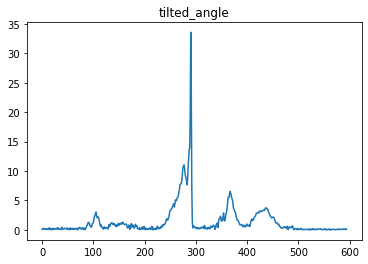

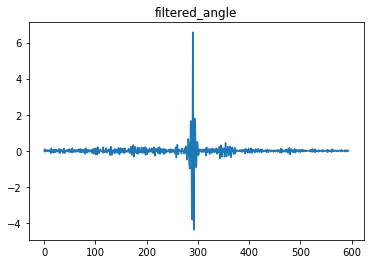

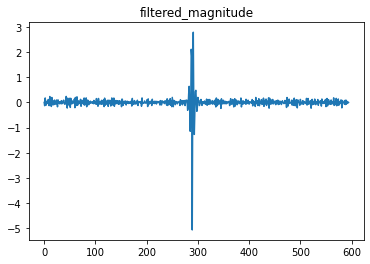

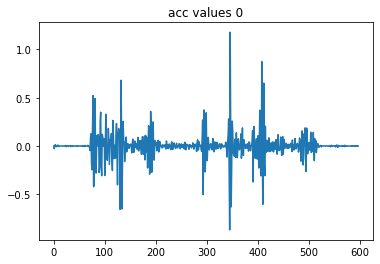

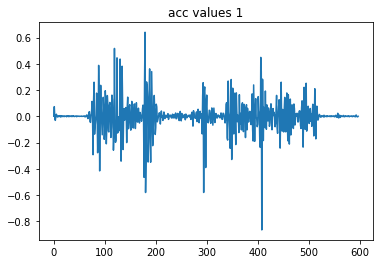

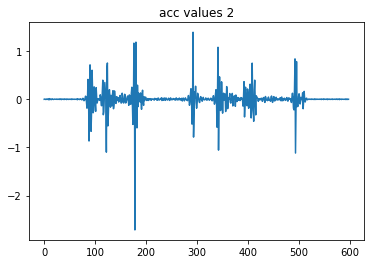

angle max 33.57782607997457  magnitude max : 5.0675645682124415

C:\Users\jaemi\lab_magacc/Data/Test_nature1/griptokBlue/Imu 2023-03-29 14-22-39
detect 491


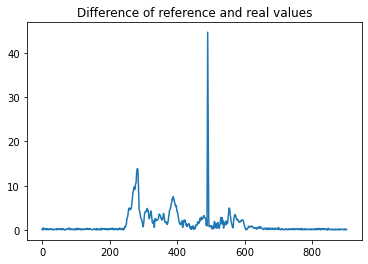

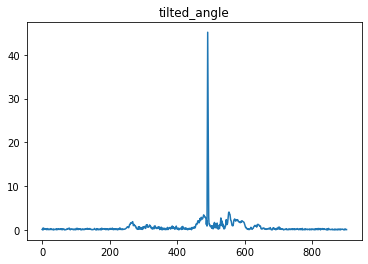

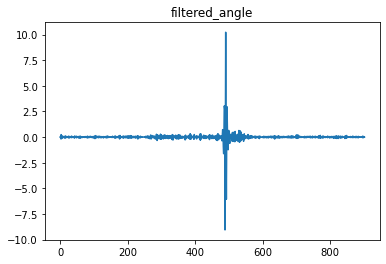

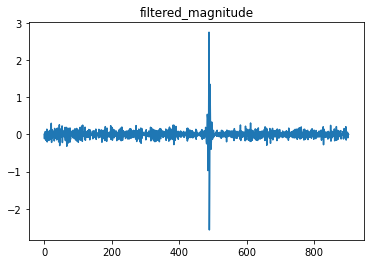

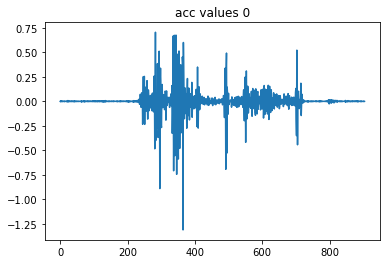

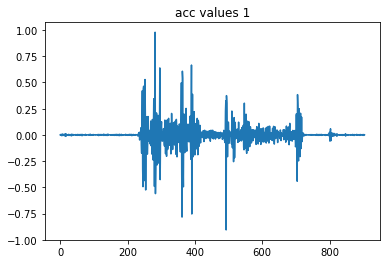

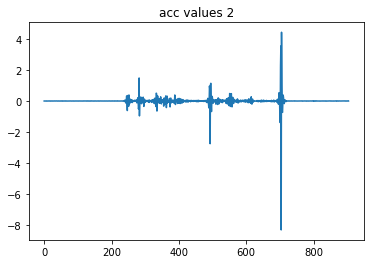

angle max 45.13965033227625  magnitude max : 2.7426776196510314

C:\Users\jaemi\lab_magacc/Data/Test_nature1/griptokBlue/Imu 2023-03-29 14-22-58
detect 415


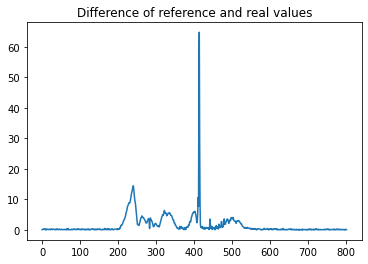

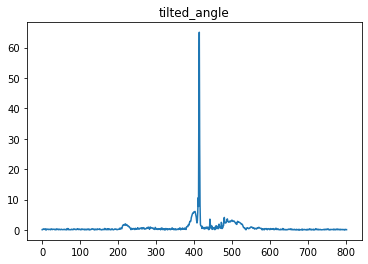

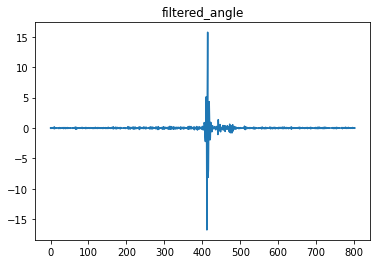

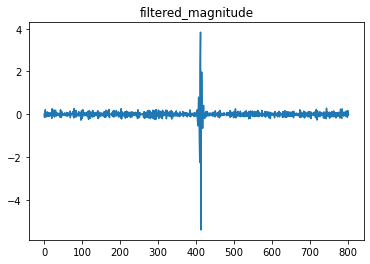

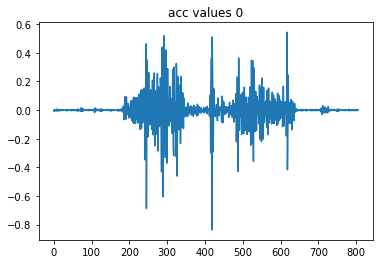

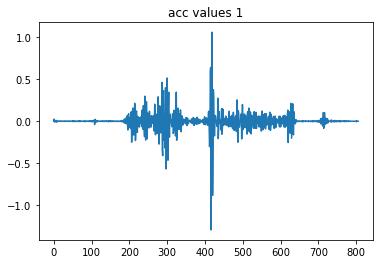

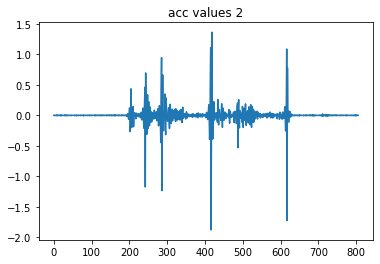

angle max 65.03115002574448  magnitude max : 5.403411010656257

C:\Users\jaemi\lab_magacc/Data/Test_nature1/griptokBlue/Imu 2023-03-29 14-23-13
detect 348


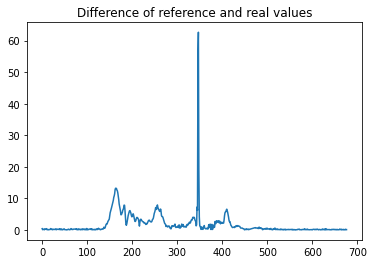

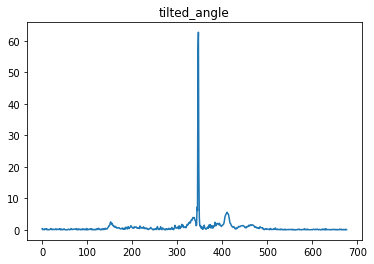

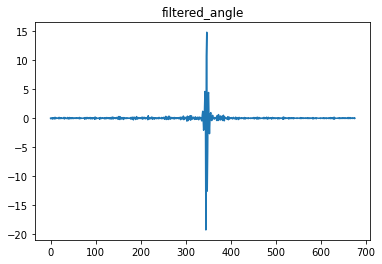

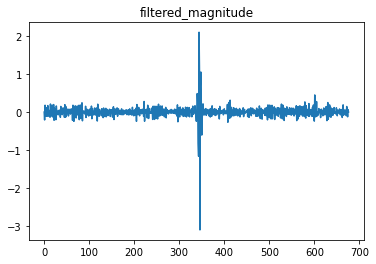

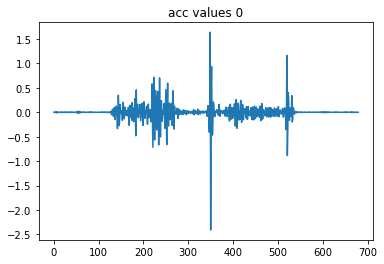

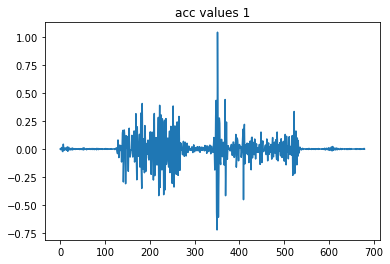

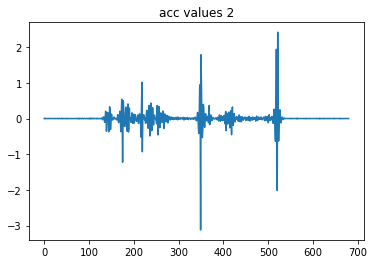

angle max 62.72347707569885  magnitude max : 3.103674103848693

C:\Users\jaemi\lab_magacc/Data/Test_nature1/griptokBlue/Imu 2023-03-29 14-23-29
detect 388


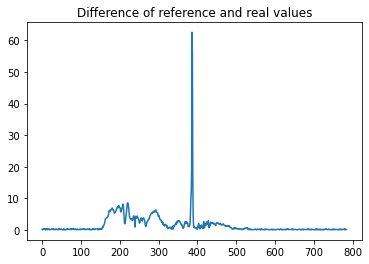

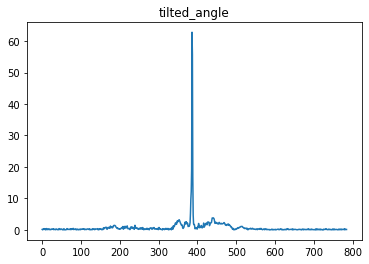

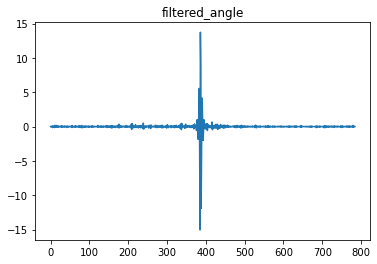

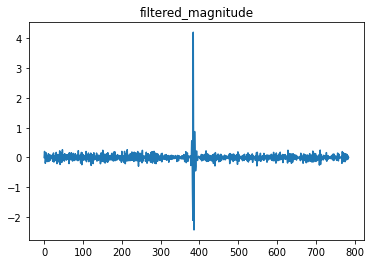

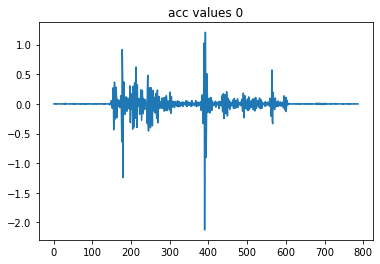

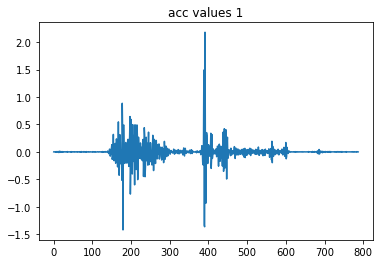

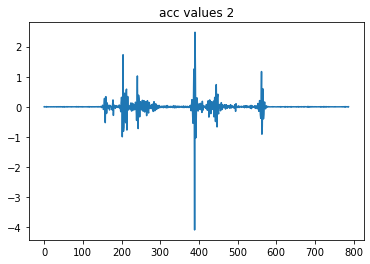

angle max 62.795608603276655  magnitude max : 4.2090614572755705

C:\Users\jaemi\lab_magacc/Data/Test_nature1/griptokBlue/Imu 2023-03-29 14-30-33
detect 419


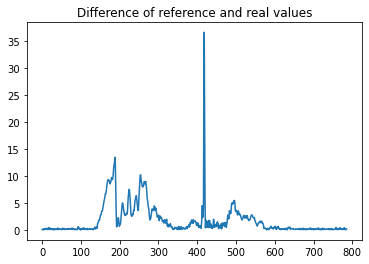

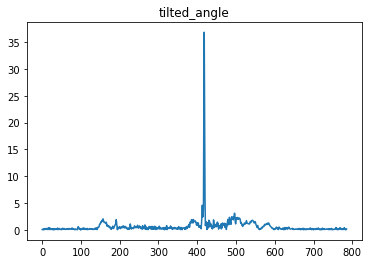

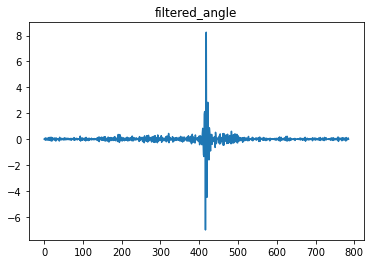

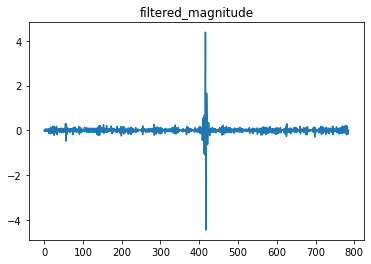

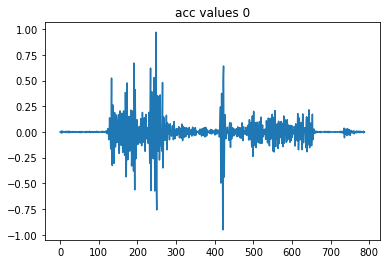

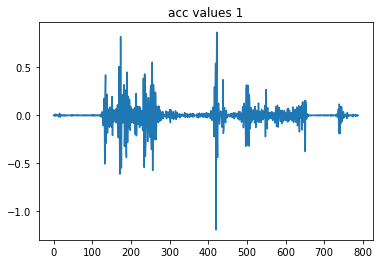

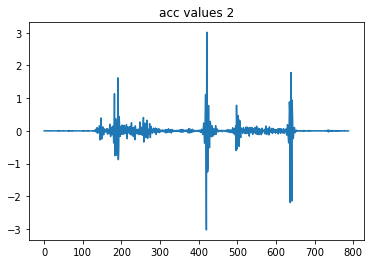

angle max 36.847050279185204  magnitude max : 4.450793487188103

C:\Users\jaemi\lab_magacc/Data/Test_nature1/iamdueChargerWhite/Imu 2023-03-29 15-19-48


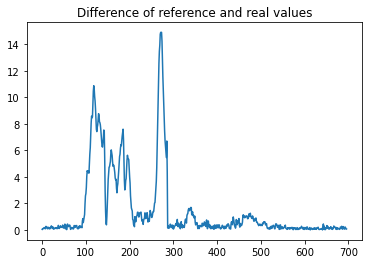

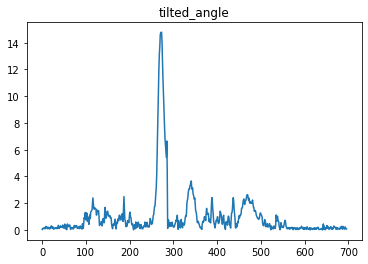

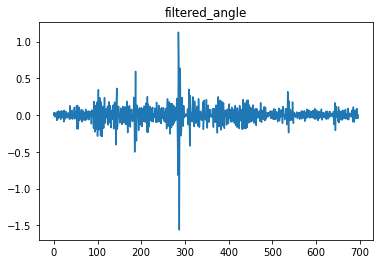

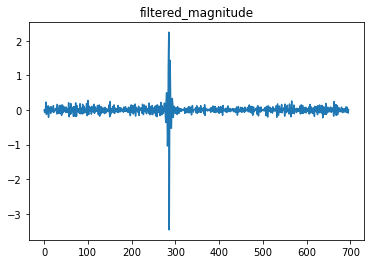

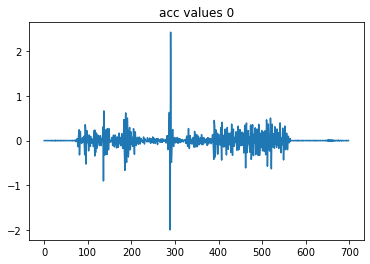

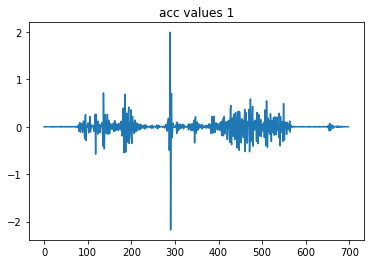

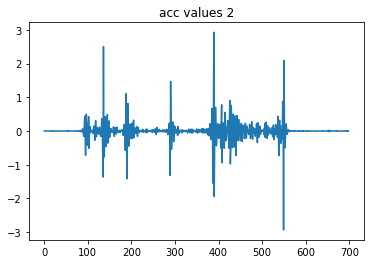

angle max 14.785323347705685  magnitude max : 3.4679566816302514

C:\Users\jaemi\lab_magacc/Data/Test_nature1/iamdueChargerWhite/Imu 2023-03-29 15-20-05


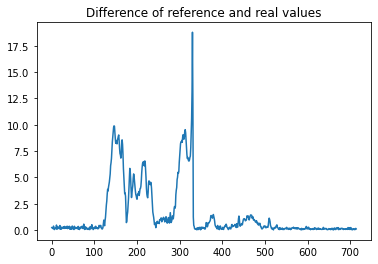

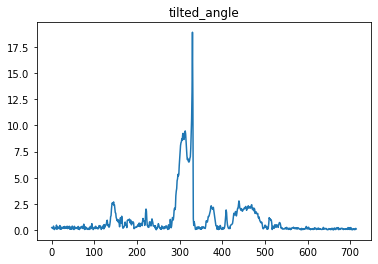

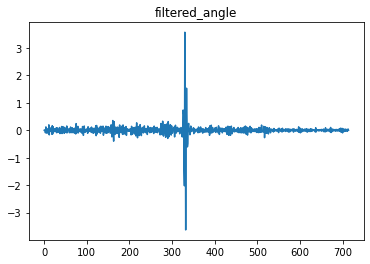

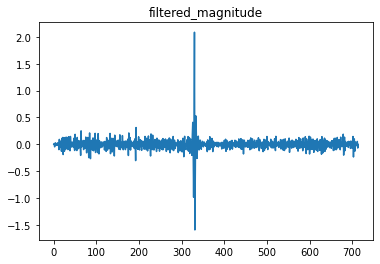

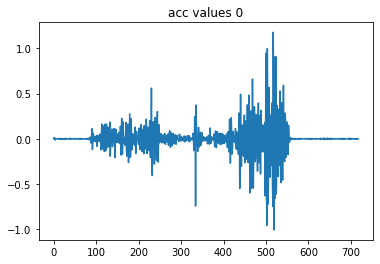

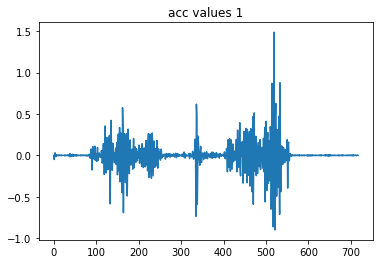

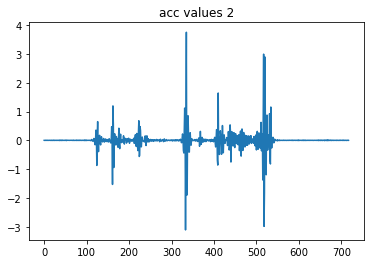

angle max 18.921169861953498  magnitude max : 2.085084431418452

C:\Users\jaemi\lab_magacc/Data/Test_nature1/iamdueChargerWhite/Imu 2023-03-29 15-20-24
detect 289


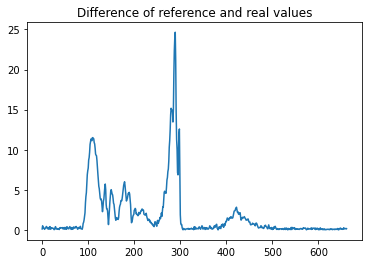

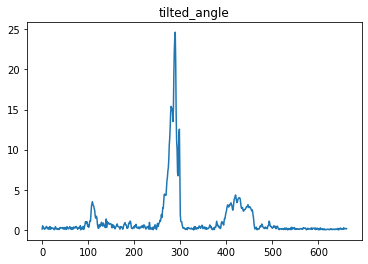

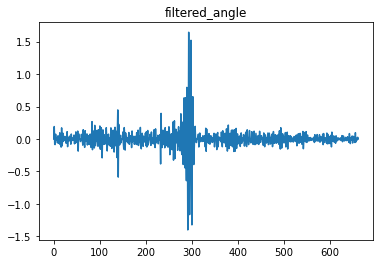

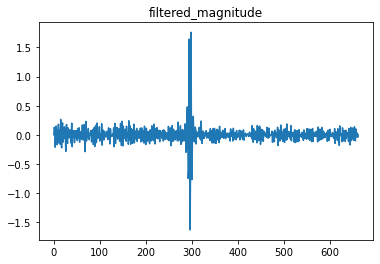

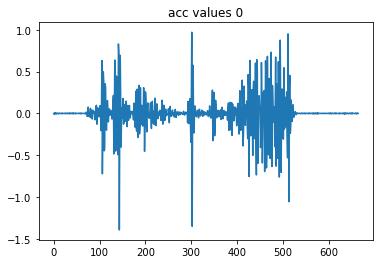

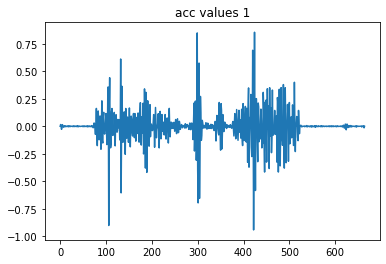

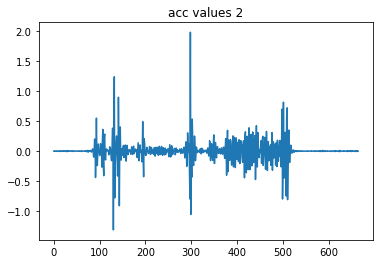

angle max 24.621022769476056  magnitude max : 1.7607389882826345

C:\Users\jaemi\lab_magacc/Data/Test_nature1/iamdueChargerWhite/Imu 2023-03-29 15-20-39
detect 276


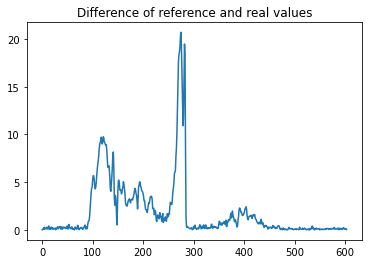

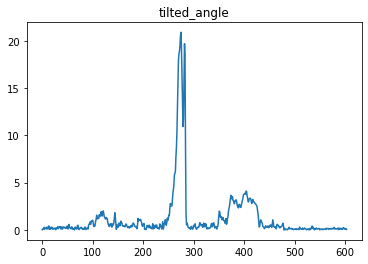

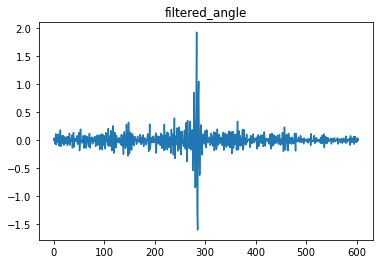

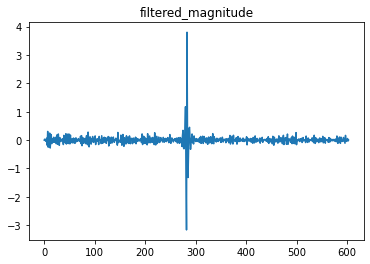

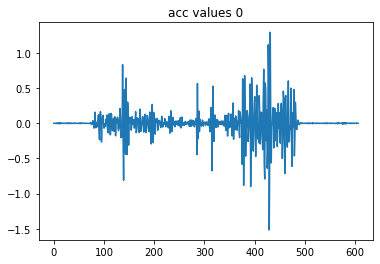

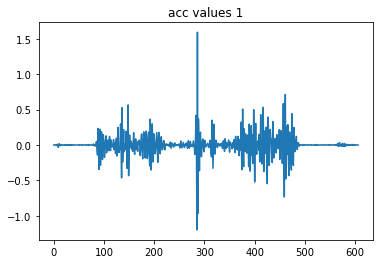

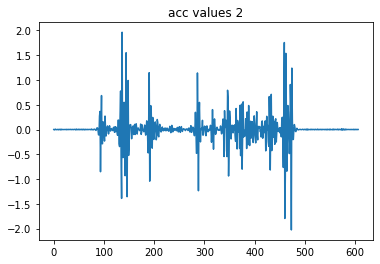

angle max 20.895407588690958  magnitude max : 3.798688718192217

C:\Users\jaemi\lab_magacc/Data/Test_nature1/iamdueChargerWhite/Imu 2023-03-29 15-20-56


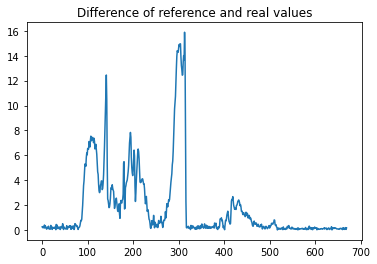

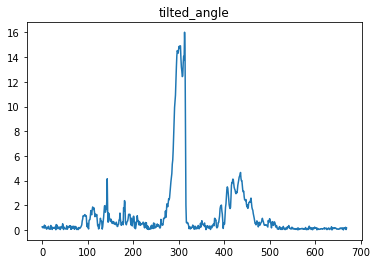

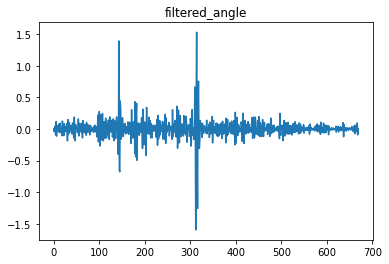

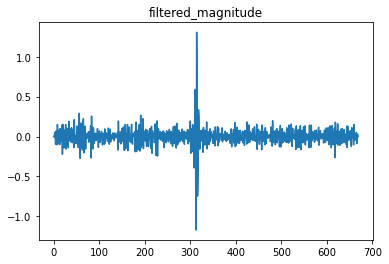

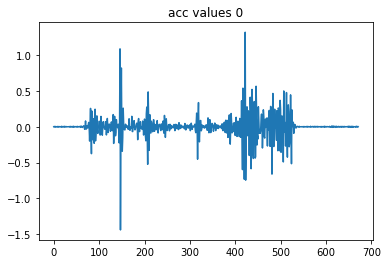

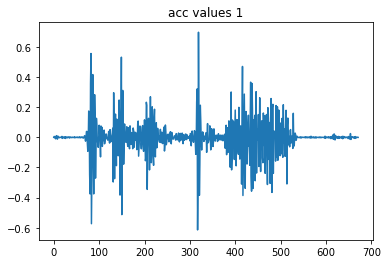

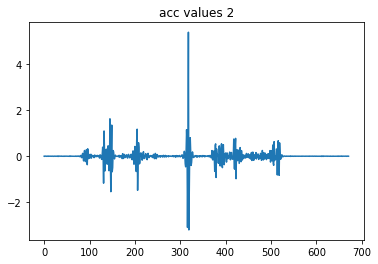

angle max 16.016806154906707  magnitude max : 1.3079764962797433

C:\Users\jaemi\lab_magacc/Data/Test_nature1/mlinggoslotBlack/Imu 2023-03-29 14-43-43
detect 392


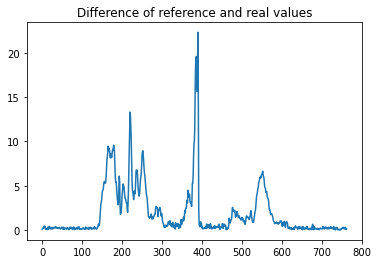

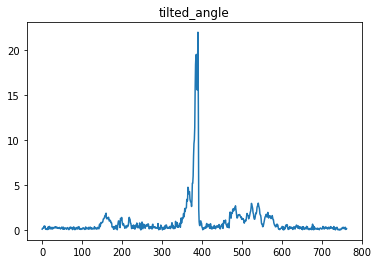

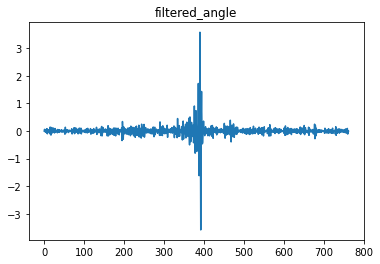

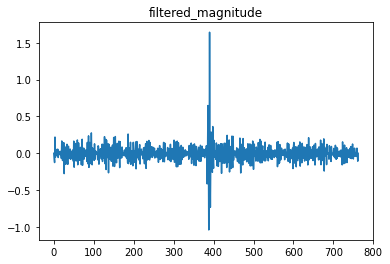

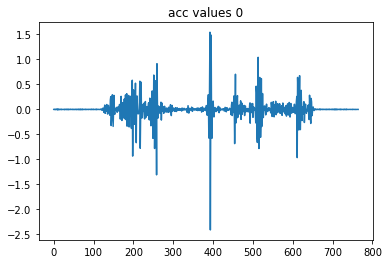

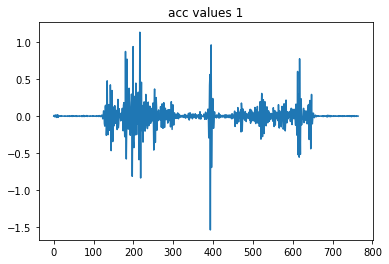

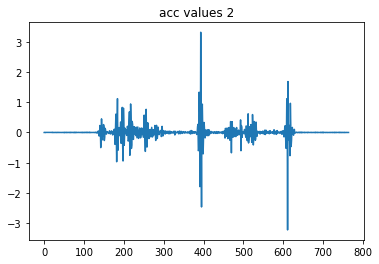

angle max 21.932552557466543  magnitude max : 1.6422912871377915

C:\Users\jaemi\lab_magacc/Data/Test_nature1/mlinggoslotBlack/Imu 2023-03-29 14-44-01


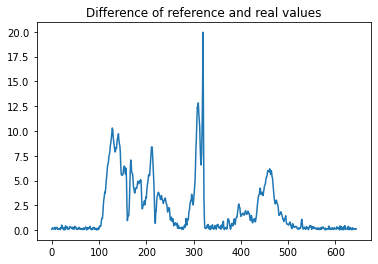

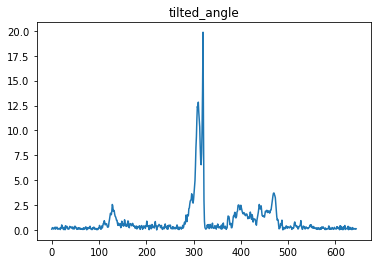

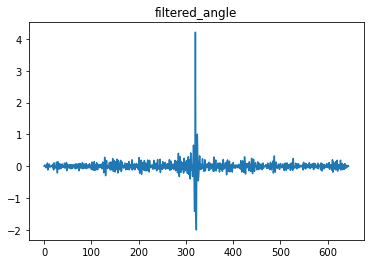

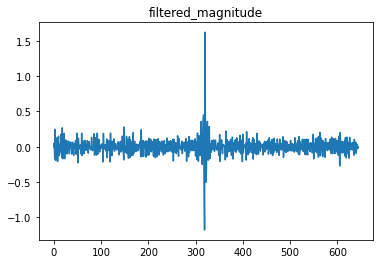

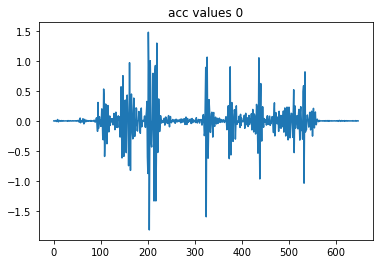

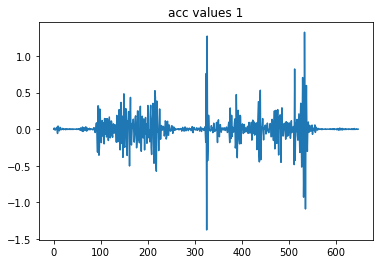

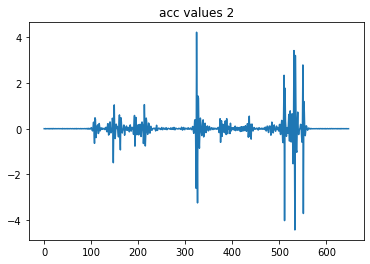

angle max 19.86103619949291  magnitude max : 1.6221673950818423

C:\Users\jaemi\lab_magacc/Data/Test_nature1/mlinggoslotBlack/Imu 2023-03-29 14-44-18
detect 384


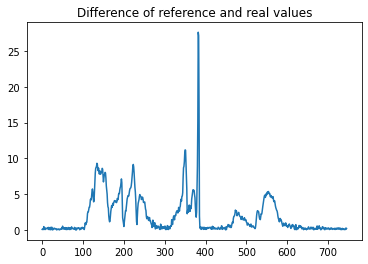

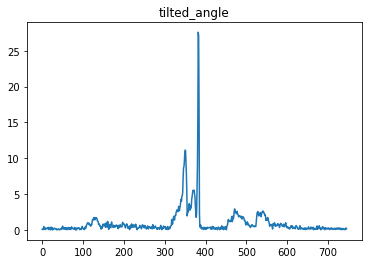

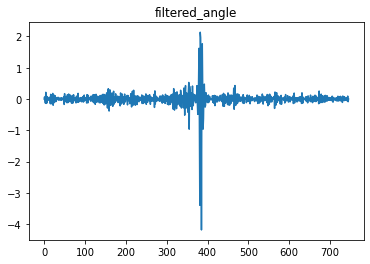

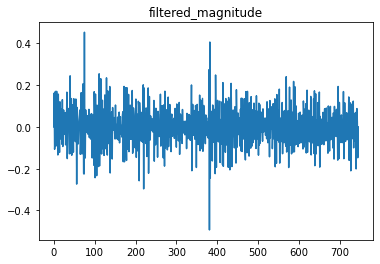

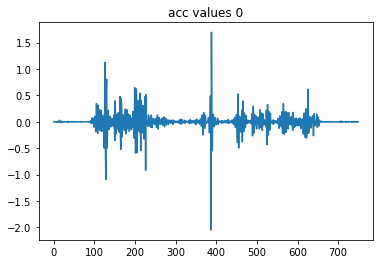

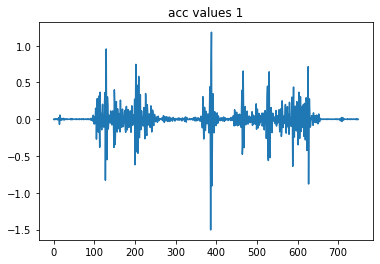

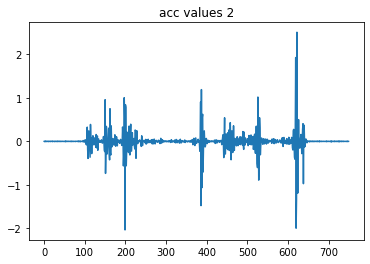

angle max 27.585885909670957  magnitude max : 0.4929844368853339

C:\Users\jaemi\lab_magacc/Data/Test_nature1/mlinggoslotBlack/Imu 2023-03-29 14-44-34
detect 322


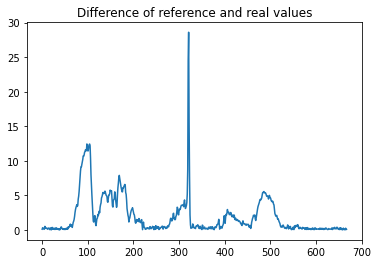

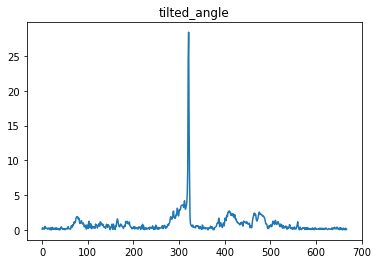

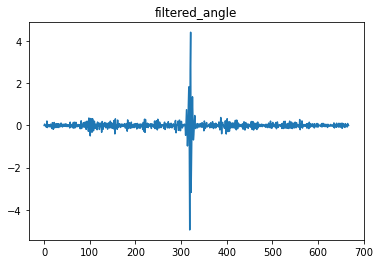

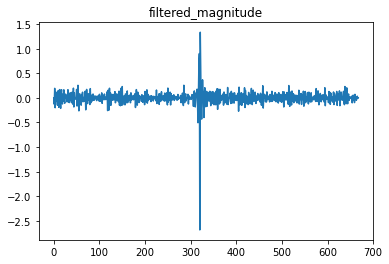

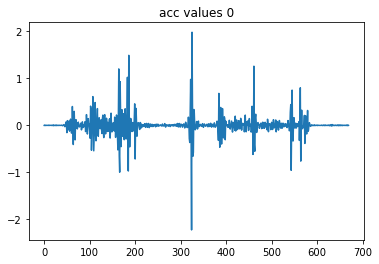

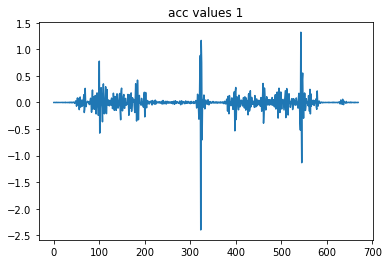

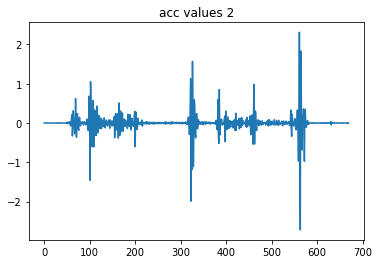

angle max 28.404051807670587  magnitude max : 2.6836655096211826

C:\Users\jaemi\lab_magacc/Data/Test_nature1/mlinggoslotBlack/Imu 2023-03-29 14-44-49


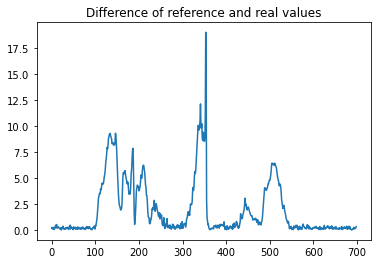

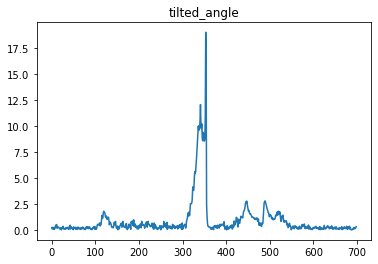

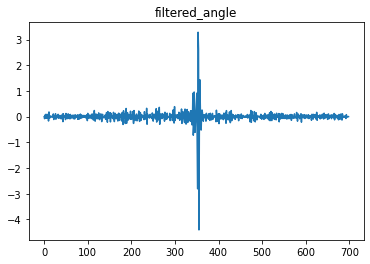

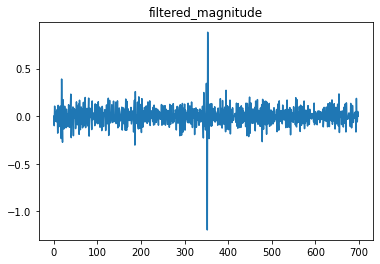

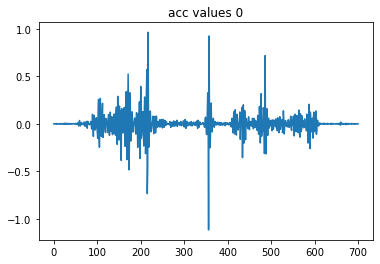

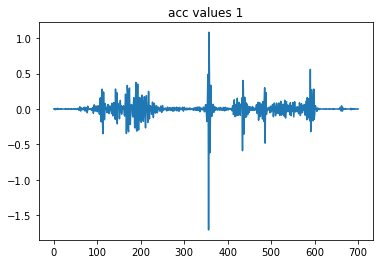

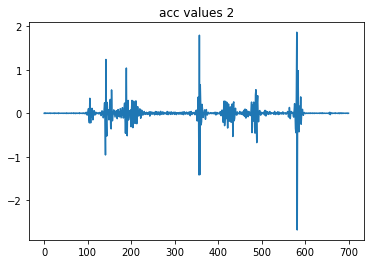

angle max 19.020233863405206  magnitude max : 1.1939415881929216

C:\Users\jaemi\lab_magacc/Data/Test_nature1/supershellWalletGreen/Imu 2023-03-29 14-34-39
detect 397


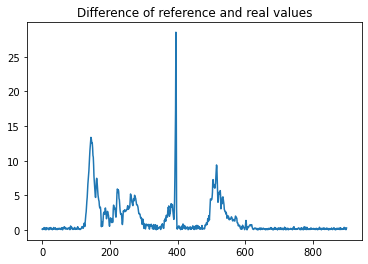

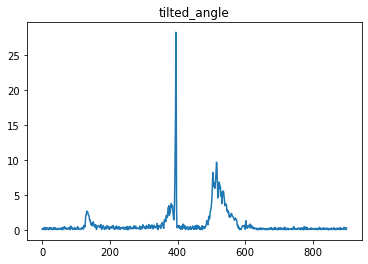

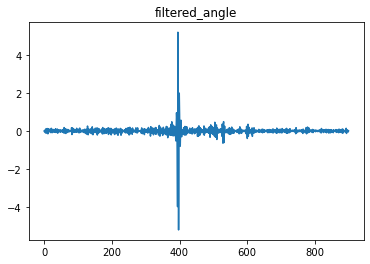

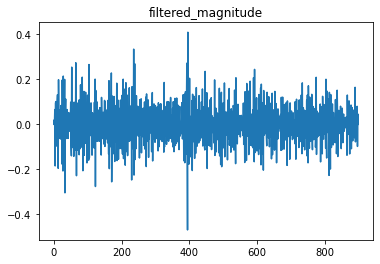

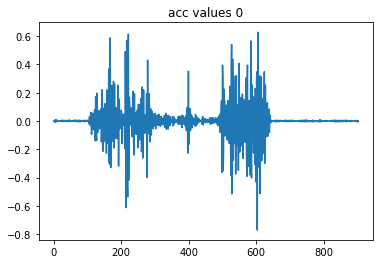

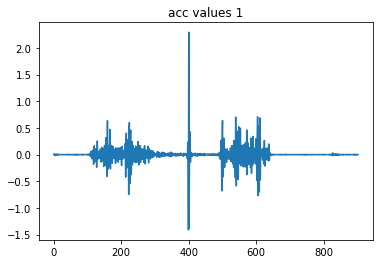

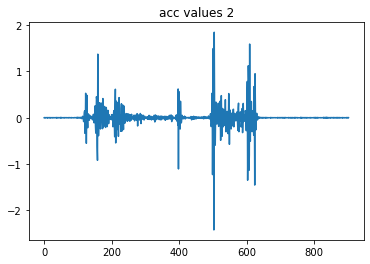

angle max 28.282581634632898  magnitude max : 0.4691454295984905

C:\Users\jaemi\lab_magacc/Data/Test_nature1/supershellWalletGreen/Imu 2023-03-29 14-35-16
detect 403


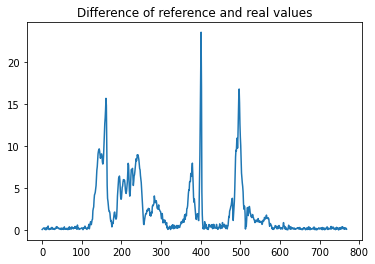

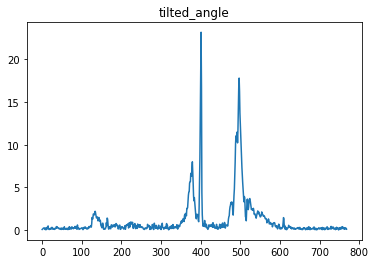

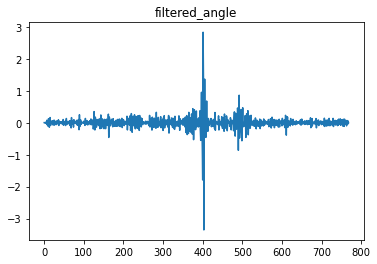

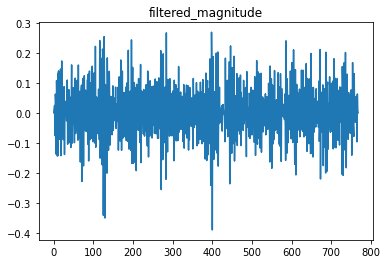

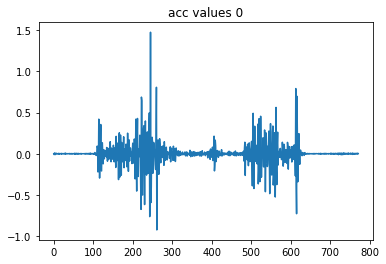

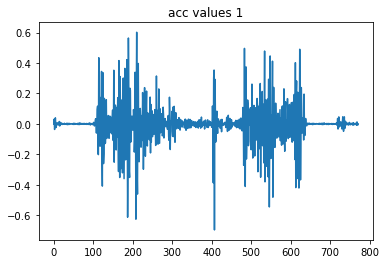

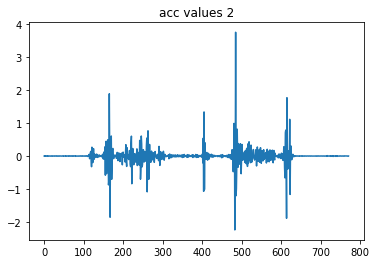

angle max 23.194943557085193  magnitude max : 0.3903706829050137

C:\Users\jaemi\lab_magacc/Data/Test_nature1/supershellWalletGreen/Imu 2023-03-29 14-35-31
detect 350


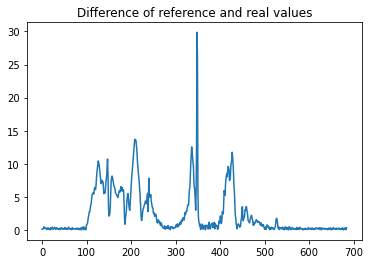

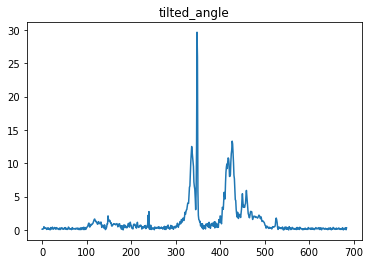

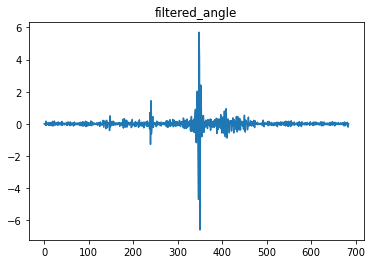

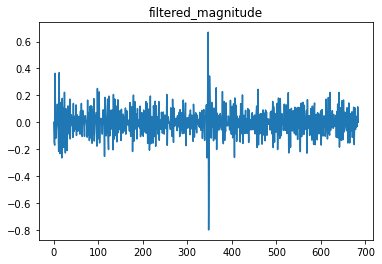

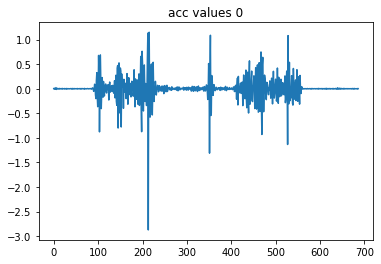

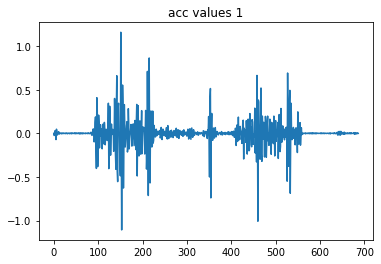

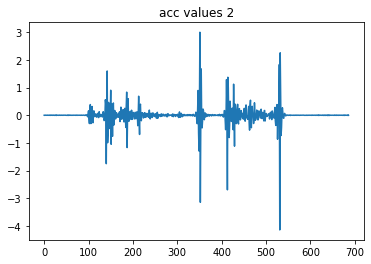

angle max 29.650575292977976  magnitude max : 0.7998960835340988

C:\Users\jaemi\lab_magacc/Data/Test_nature1/supershellWalletGreen/Imu 2023-03-29 14-35-47
detect 379


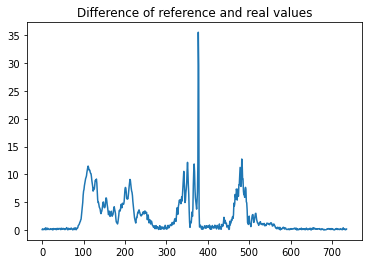

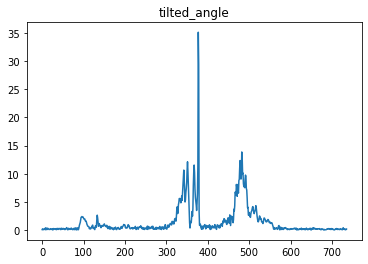

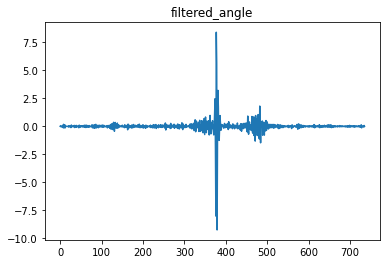

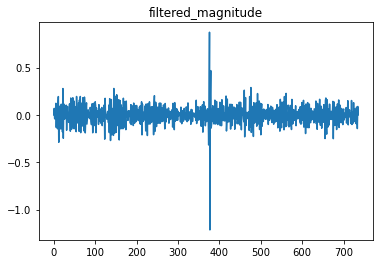

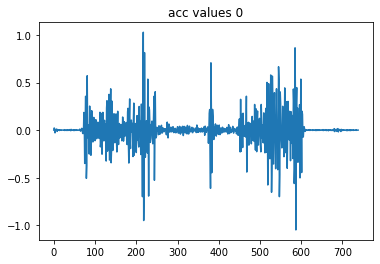

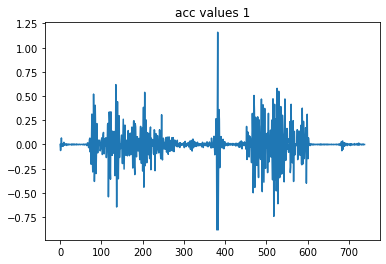

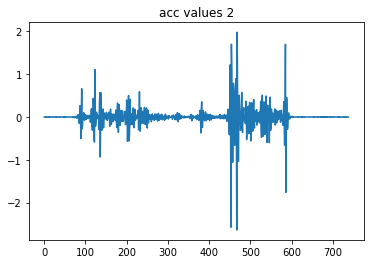

angle max 35.13395663488677  magnitude max : 1.2155102668636233

C:\Users\jaemi\lab_magacc/Data/Test_nature1/supershellWalletGreen/Imu 2023-03-29 14-36-09


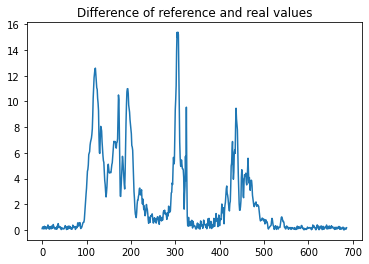

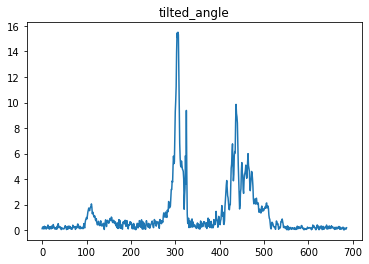

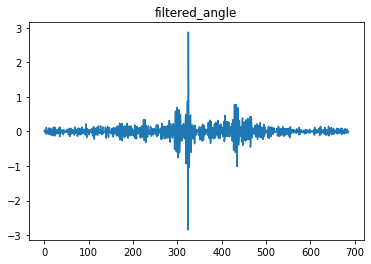

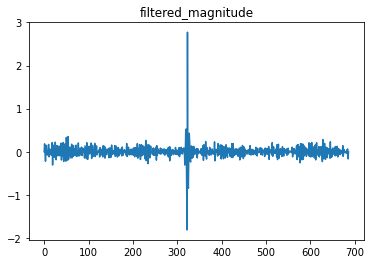

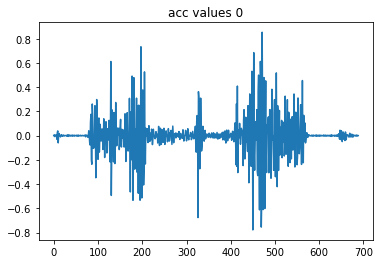

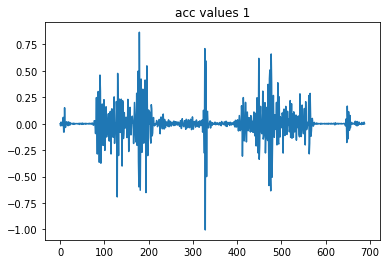

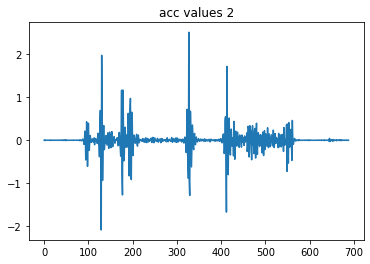

angle max 15.50608557751008  magnitude max : 2.77195474798833

C:\Users\jaemi\lab_magacc/Data/Test_nature1/vicxxoChargerWhite/Imu 2023-03-29 15-14-30
detect 262


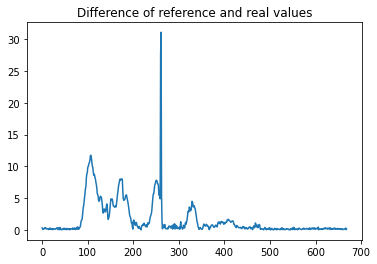

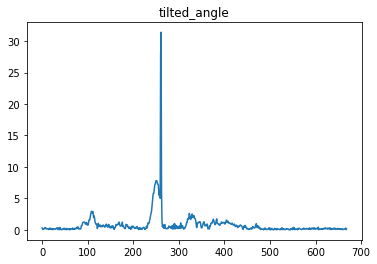

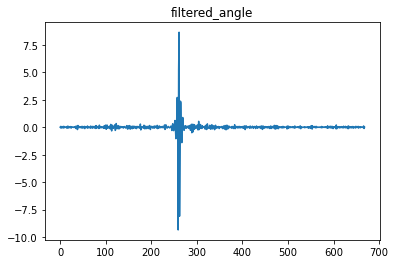

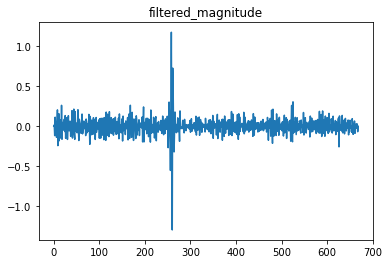

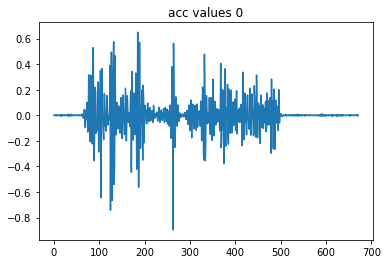

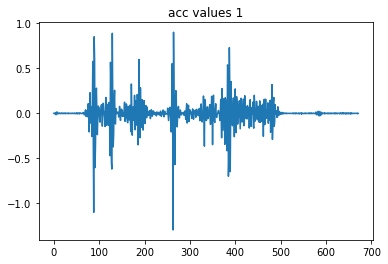

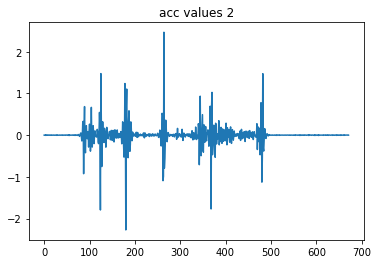

angle max 31.396182957821043  magnitude max : 1.2942079244046787

C:\Users\jaemi\lab_magacc/Data/Test_nature1/vicxxoChargerWhite/Imu 2023-03-29 15-14-47
detect 290


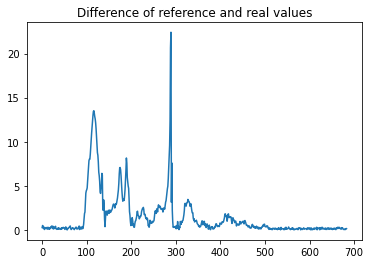

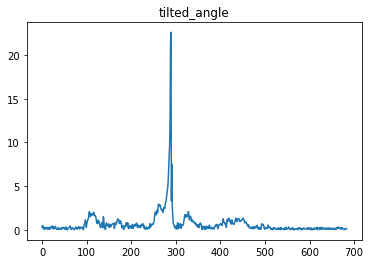

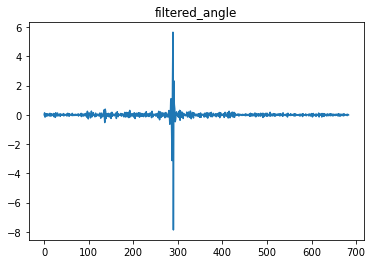

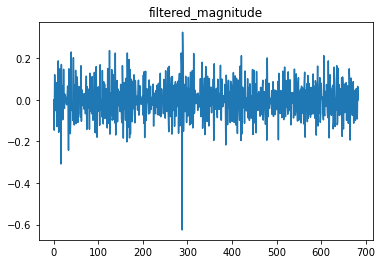

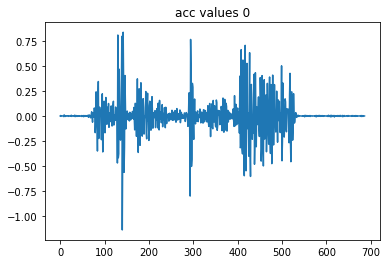

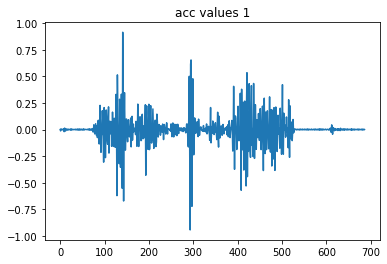

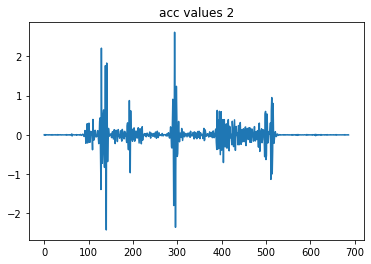

angle max 22.597248466243634  magnitude max : 0.6254017072416073

C:\Users\jaemi\lab_magacc/Data/Test_nature1/vicxxoChargerWhite/Imu 2023-03-29 15-15-03
detect 365


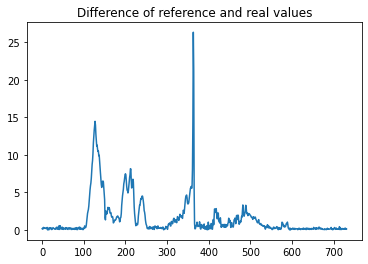

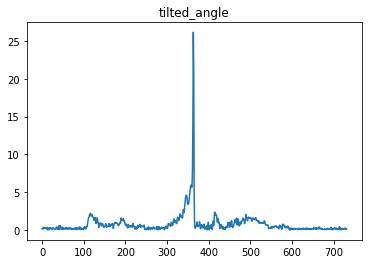

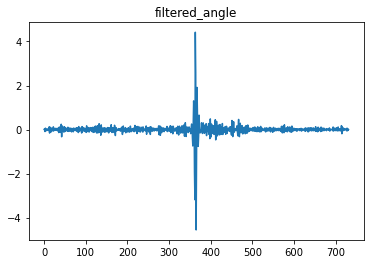

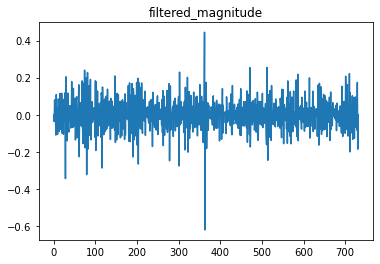

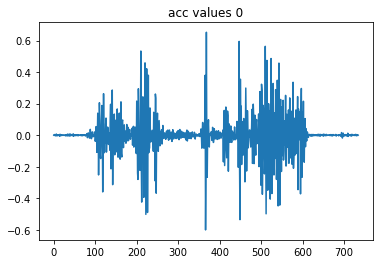

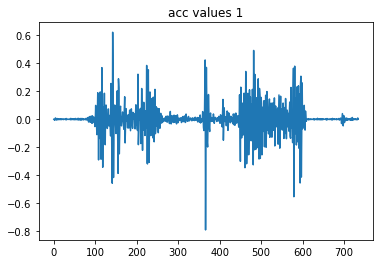

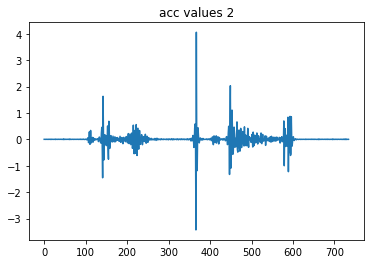

angle max 26.16268868363121  magnitude max : 0.6204265843883734

C:\Users\jaemi\lab_magacc/Data/Test_nature1/vicxxoChargerWhite/Imu 2023-03-29 15-15-19
detect 285


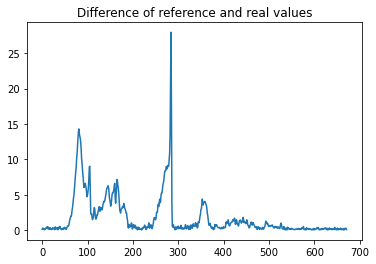

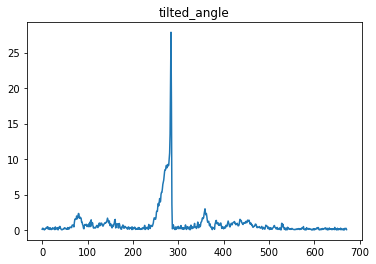

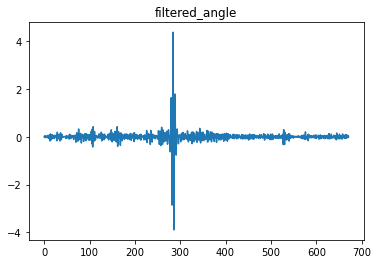

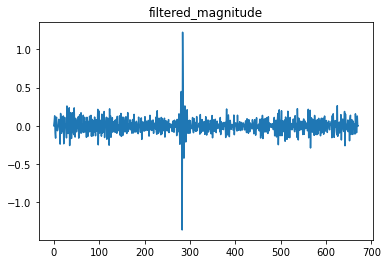

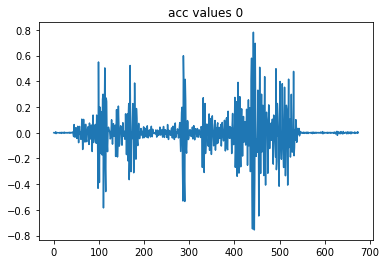

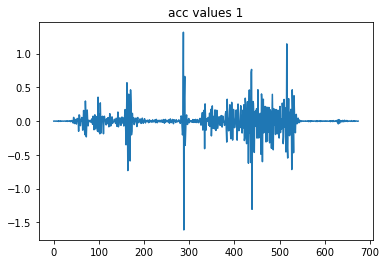

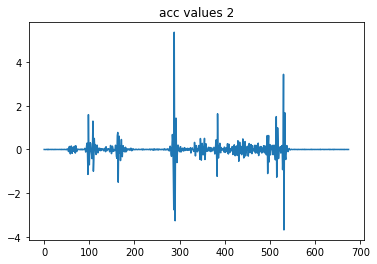

angle max 27.870263805716203  magnitude max : 1.3632130716950568

C:\Users\jaemi\lab_magacc/Data/Test_nature1/vicxxoChargerWhite/Imu 2023-03-29 15-15-38
detect 355


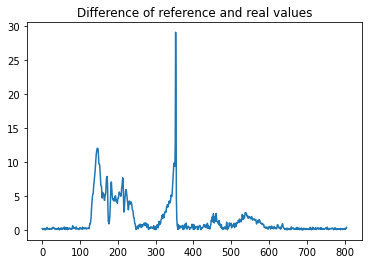

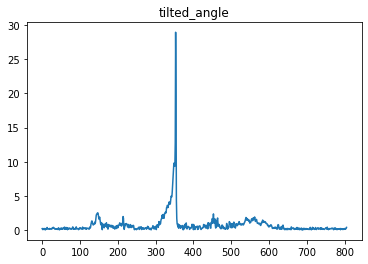

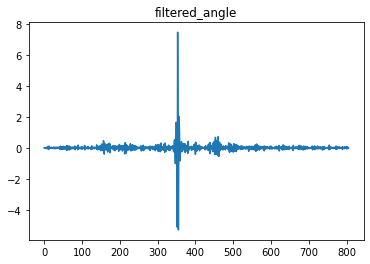

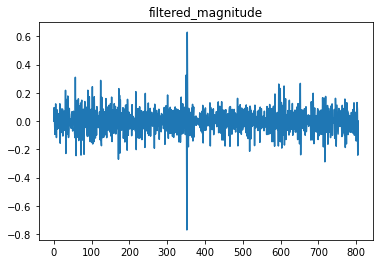

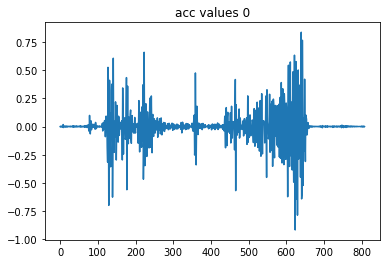

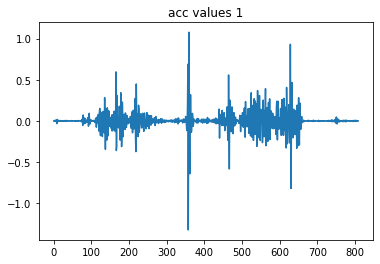

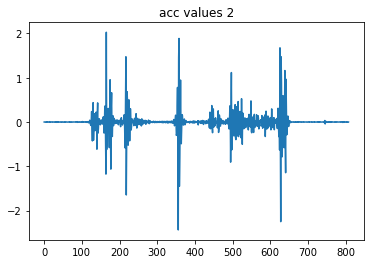

angle max 28.976795074674033  magnitude max : 0.7703402822250185

C:\Users\jaemi\lab_magacc/Data/Test_nature1/walletBrown/Imu 2023-03-29 14-31-22


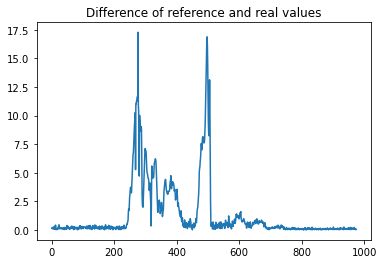

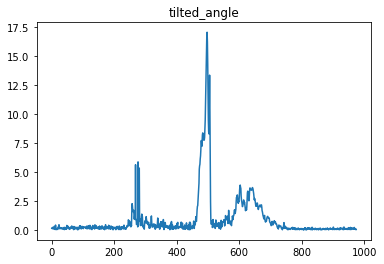

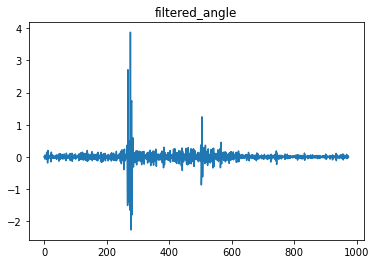

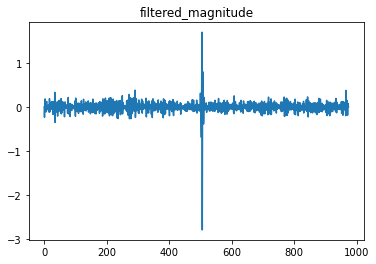

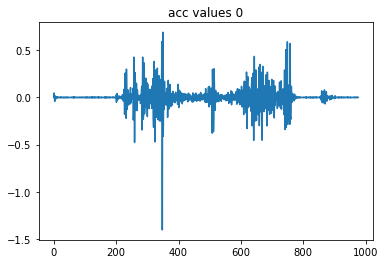

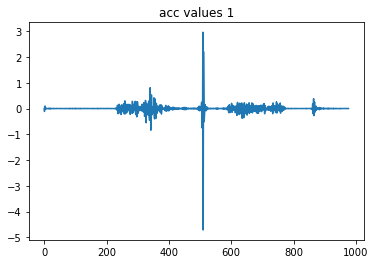

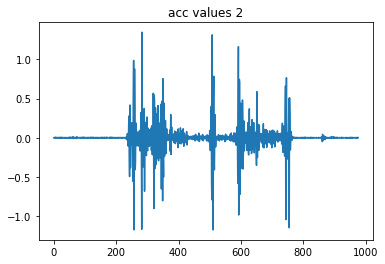

angle max 17.032620310591316  magnitude max : 2.7890537083121685

C:\Users\jaemi\lab_magacc/Data/Test_nature1/walletBrown/Imu 2023-03-29 14-31-44
detect 443


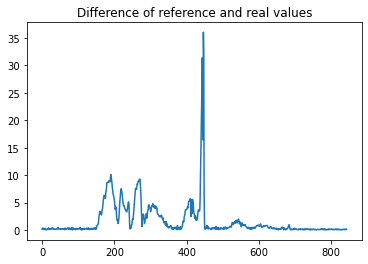

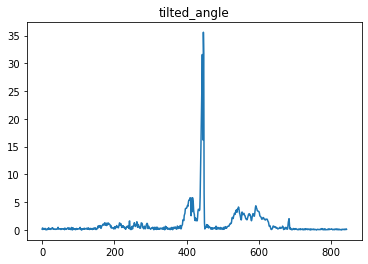

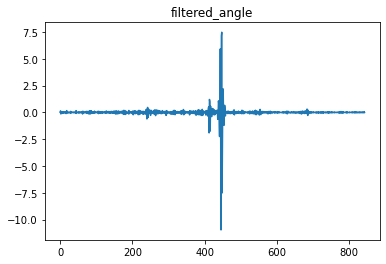

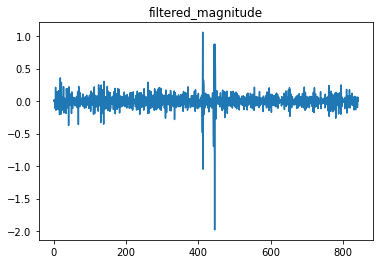

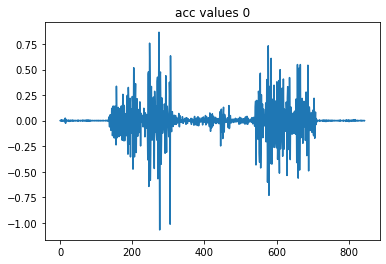

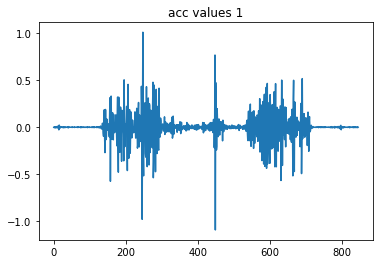

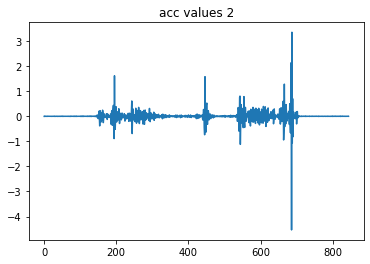

angle max 35.5914377710077  magnitude max : 1.9826895130285724

C:\Users\jaemi\lab_magacc/Data/Test_nature1/walletBrown/Imu 2023-03-29 14-32-02
detect 332


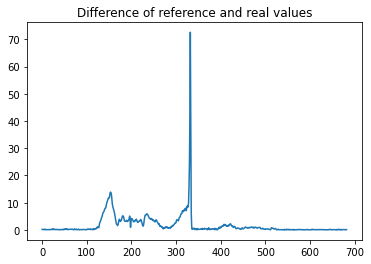

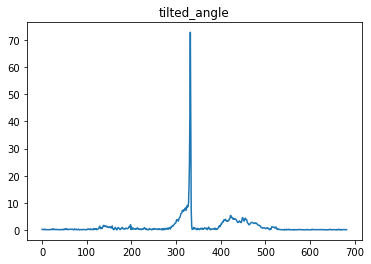

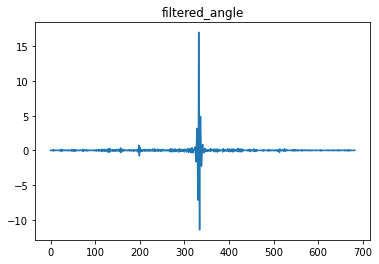

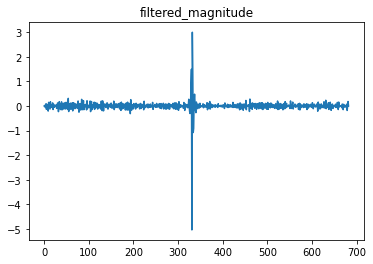

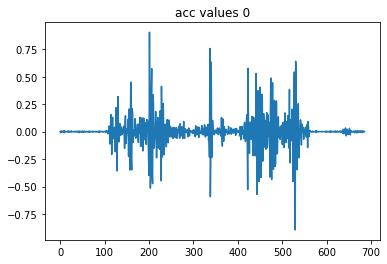

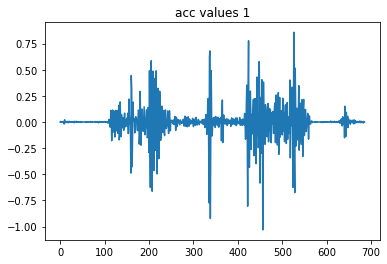

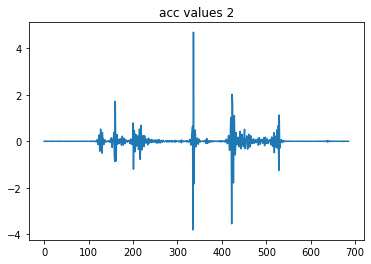

angle max 72.85918436190039  magnitude max : 5.038679705897035

C:\Users\jaemi\lab_magacc/Data/Test_nature1/walletBrown/Imu 2023-03-29 14-32-21
detect 397


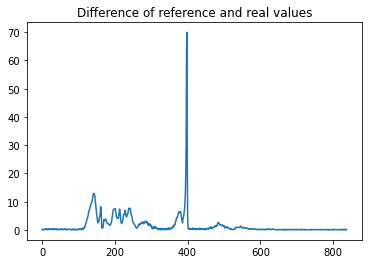

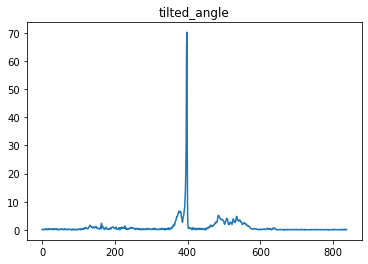

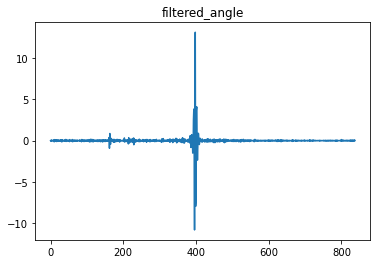

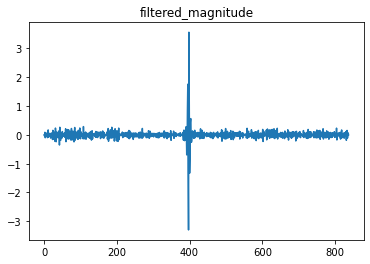

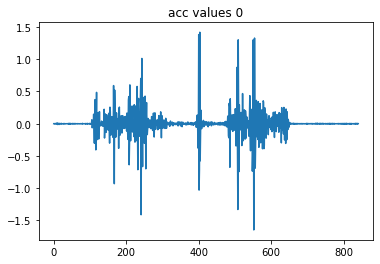

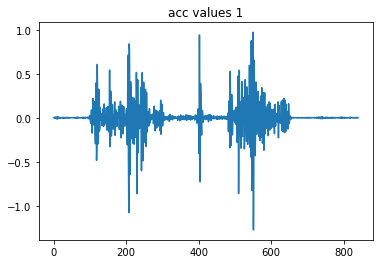

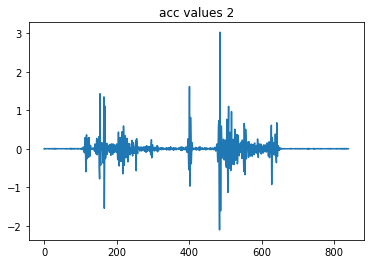

angle max 70.18903838787907  magnitude max : 3.5599259774220013

C:\Users\jaemi\lab_magacc/Data/Test_nature1/walletBrown/Imu 2023-03-29 14-32-36
detect 303


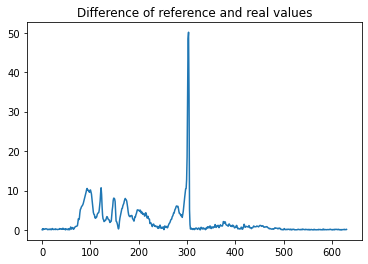

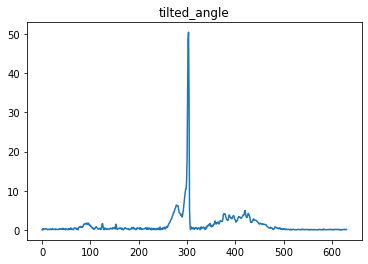

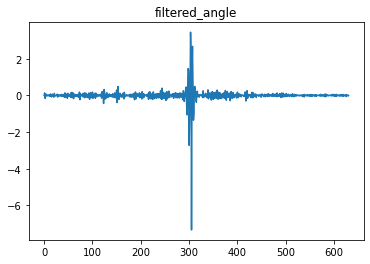

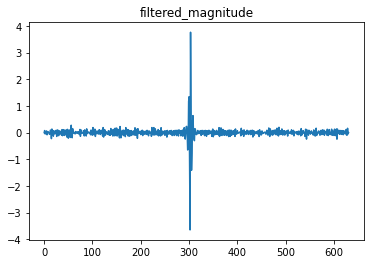

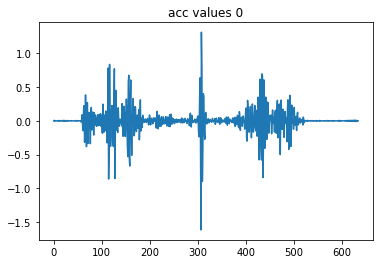

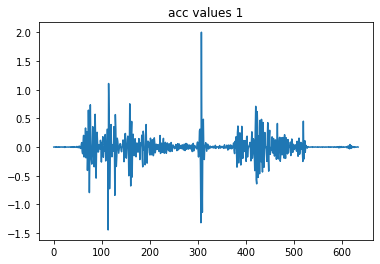

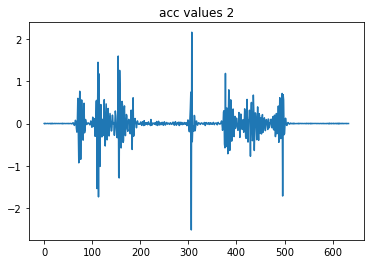

angle max 50.49962240567336  magnitude max : 3.763357734465304



In [80]:
class Values():
    def __init__(self):
        self.angles = []
        self.magnitudes = []
        
    def append_values(self, angle, magnitude):
        self.angles.append(angle)
        self.magnitudes.append(magnitude)

path = data_cwd + 'Test_nature1'
#path = data_cwd + 'Test_inside'
imu_data = IMU(path)

start, end = 0, 65
b, a = signal.butter(5, 20/(100/2), btype='highpass')

label_values = {label : Values() for label in labels}

for i in range(start, end):
    f = imu_data[i]
    print(f.path)
    data = f.data
    
    tmp = MagInfer(data)
    tilted_angle = tmp.solve(ws = 0.02)
    
    plot_graph(tmp.diff_ref_real, 'Difference of reference and real values')
    plot_graph(tilted_angle, title= 'tilted_angle')
    filtered_data = signal.filtfilt(b, a, tilted_angle)
    plot_graph(filtered_data, 'filtered_angle')
    
    magnitude = tmp.magnitudes
    filtered_data = signal.filtfilt(b, a, magnitude)
    plot_graph(filtered_data, 'filtered_magnitude')
    
    angle_max = abs(max(tilted_angle)) if abs(max(tilted_angle)) > abs(min(tilted_angle)) else abs(min(tilted_angle))
    mag_max = abs(max(filtered_data)) if abs(max(filtered_data)) > abs(min(filtered_data)) else abs(min(filtered_data))
    label_values[f.label].append_values(angle_max, mag_max)
    
    # for mags
    for t in range(3):
        #plot_graph(tmp.mag[t], title = 'mag values ' + str(t))
        filtered_data = signal.filtfilt(b, a, tmp.acc[t])
        plot_graph(filtered_data, title = 'acc values ' + str(t))
        #plot_graph(filtered_data, title = 'mag values ' + str(t))
        
    
    print('angle max {}  magnitude max : {}\n'.format(angle_max, mag_max))

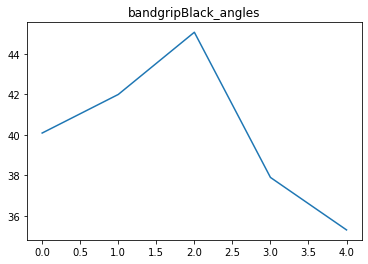

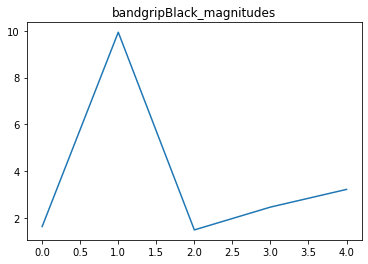

---------------------------------------------------


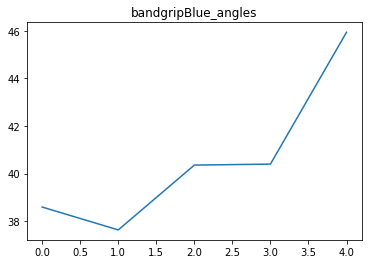

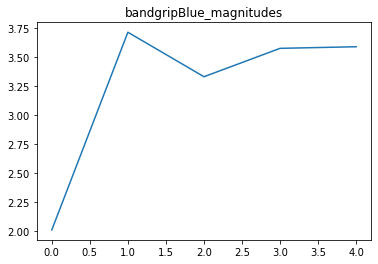

---------------------------------------------------


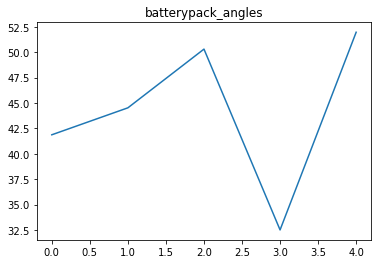

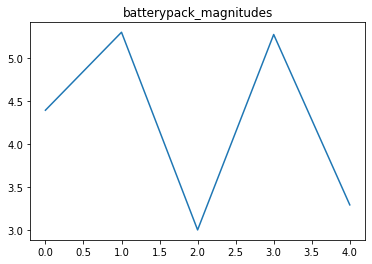

---------------------------------------------------


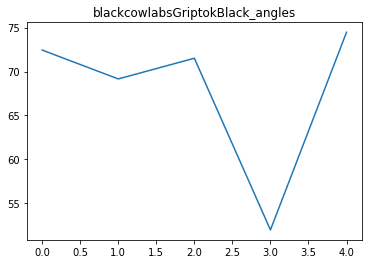

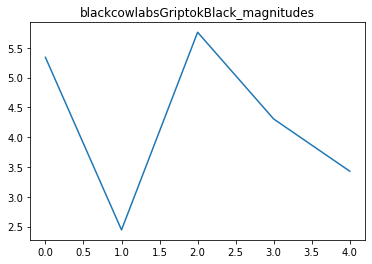

---------------------------------------------------


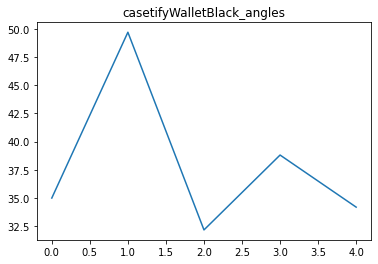

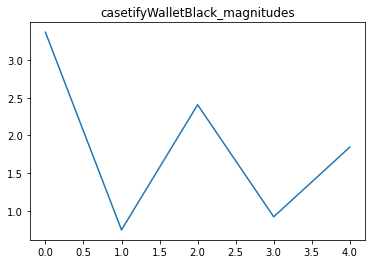

---------------------------------------------------


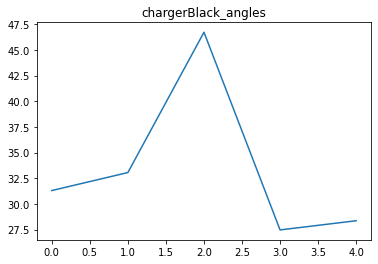

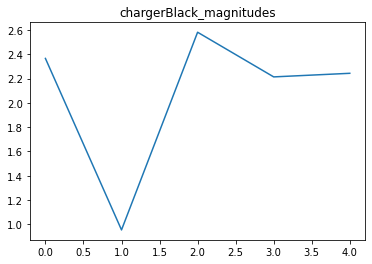

---------------------------------------------------


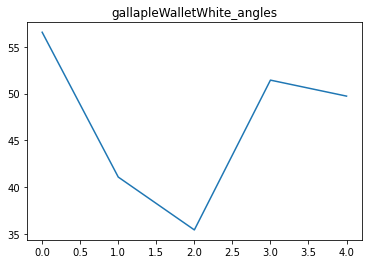

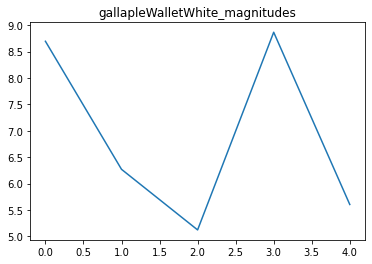

---------------------------------------------------


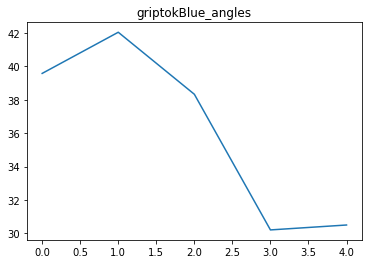

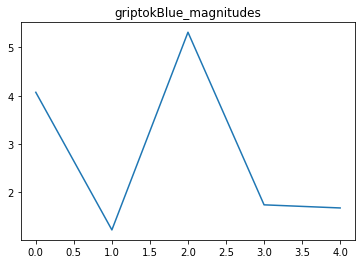

---------------------------------------------------


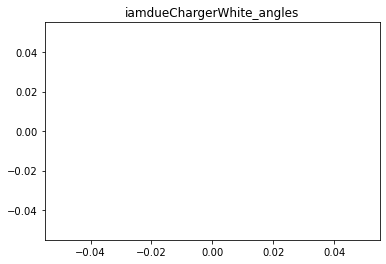

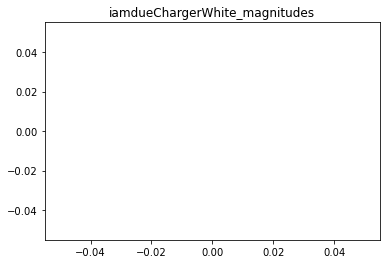

---------------------------------------------------


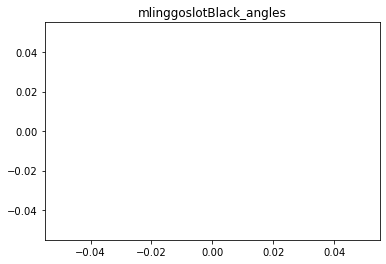

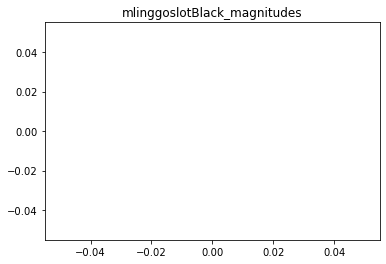

---------------------------------------------------


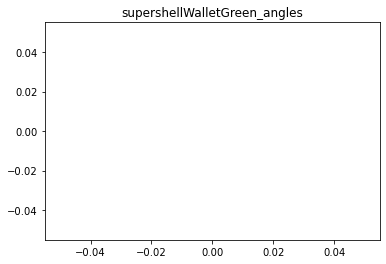

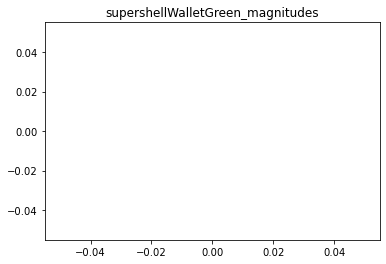

---------------------------------------------------


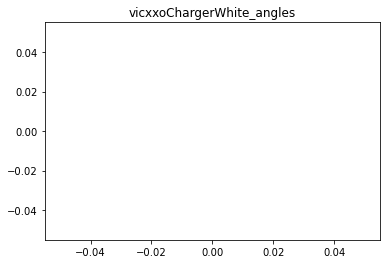

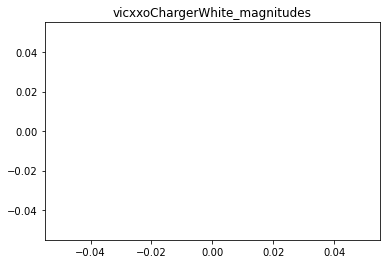

---------------------------------------------------


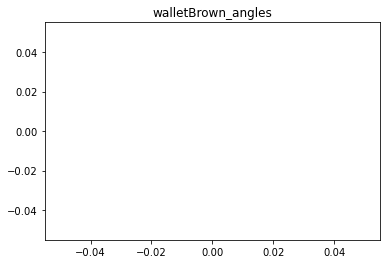

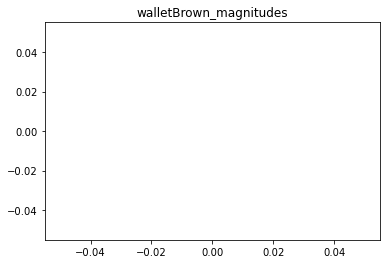

---------------------------------------------------


In [51]:
for key, value in label_values.items():
    plot_graph(value.angles, title = key + '_angles')
    plot_graph(value.magnitudes, title = key + '_magnitudes')
    print('---------------------------------------------------')